<a href="https://colab.research.google.com/github/rachboyle/mixed_methods_b2b_personas_generation/blob/main/clustering_iterations_1_and_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Web Analytics Clustering: 1st and 2nd Iterations

In [ ]:
#Authenticate to GCP to access survey and web analytics data in BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


##Iterative Mixed Method Approach to B2B SaaS User Personas Overview
Below is an overview of the various analysis and clustering steps we took for our persona generation research. This particular notebook focuses on the step(s) highlighted in yellow: 

1.   **Survey Data Pre-Processing**: Survey data cleaning and pre-processing
2.   **Survey Clustering**: Initial survey clustering to produce rudimentary personas we could use for interview recruitment
3.   **Analytcs Data Pre-Processing**: Web analytics data (from [Pendo](https://www.pendo.io) tool) pre-processing, manipulation, and sanitization tool
4.   **Preprocessing and Clustering Iterations**: Four iterations of preprocessing and clustering on the web analytics data; the following iterations listed below contain the clustering algorithm, dimensionality reduction method, and data pre-processing manipulation respectively
    * <mark>*KMeans, PCA, Averaged Data*
    * <mark>*KMeans, PCA, Percentage Usage Data Per Day*
    * *KMeans, UMAP, Percentage Usage Data Per Day*
    * *HDBScan, UMAP, Percentage Usage Data Per Week*







##Imports

In [ ]:
#Install UMAP (dimensionality reduction) and HDBscan (clustering algorithm)
!pip install umap-learn
!pip install hdbscan

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import display_html
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.rcParams.update({'figure.max_open_warning': 0}) #set so you do not get warnings

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize, StandardScaler

##Functions

In [ ]:
scaler = StandardScaler()

In [ ]:
#Function that displays dfs side by side in the report cluster function
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

#Function that helps find the optimal number of clusters by using the Elbow Method
def plot_elbow_curve(df, title):
  wcss = []
  for k in range(1,20):
      kmeans = KMeans(n_clusters=k, init="k-means++")
      kmeans.fit(df.iloc[:,1:])
      wcss.append(kmeans.inertia_)
  plt.figure(figsize=(12,6))    
  plt.plot(range(1,20),wcss, linewidth=2, color="red", marker ="8")
  plt.grid(True)
  plt.xlabel("K Value")
  plt.xticks(np.arange(2,20,2))
  plt.ylabel("WCSS")
  plt.title(title)
  plt.show()

#Find optimal number of features to reduce to by the number of features that allow us to capture 90% of the data's variance
def plot_pca_variance_to_features(num_features, df):
  pca_all_features = PCA(n_components=num_features) #total number of features in the dataset = 447
  data = pca_all_features.fit_transform(df)

  variance = np.cumsum(np.round(pca_all_features.explained_variance_ratio_, decimals=3) * 100)

  plt.ylabel('% Variance Explained')
  plt.xlabel('No. of Features')
  plt.title('PCA Analysis')
  plt.ylim(20, 110)
  plt.xlim(0,(5 * round(num_features / 5)))
  plt.plot(variance)
  plt.show()

#Perform K Means clustering and find averages for each cluster
def kmeans_clustering_aves(k, data, df, cluster_name):
  #data is the normalized, dimensionality reduced (pca. umap) version of df
  model = KMeans(n_clusters=k, init='k-means++', n_init=20)
  label = model.fit_predict(data)

  plt.figure(figsize=(15,15))
  uniq = np.unique(label)
  for i in uniq:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label=i)
  plt.xlabel([])
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  plt.show()

  df[cluster_name] = label
  summary = df.groupby([cluster_name]).mean()
  summary['count'] = df[cluster_name].value_counts()
  summary = summary.sort_values(by='count', ascending=False)
  
  return summary

#Plot the averages for each cluster and rank the top visited/used pages and features
def cluster_means_and_plots_both(summary, n, cluster_num):
  p_colormap= cm.rainbow(np.linspace(0, 1, len(page_names)))

  #Get total number of individuals to calculate % of users in each cluster
  cnt = summary['count'].sum() 

  row = summary.loc[cluster_num]

  print("\n")
  print("PERSONA CLUSTER:", cluster_num, "\n")
  print("NUMBER OF USERS IN CLUSTER:", row["count"], "\n")
  print("PERCENTAGE OF USERS IN CLUSTER:", round(100*row["count"]/cnt, 3), "\n") 
  
  page_cluster_df = pd.DataFrame(index = page_names)
  if (len(p_ids) > 0):
    #Rank pages by most time spent per day  
    page_cluster_df.insert(0,"page", row[p_ids].values)
    page_cluster_df.sort_values(by=["page"], ascending=False, inplace=True)

    #Do separate bar graphs for features and pages
    # plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(page_cluster_df.index.to_list(), page_cluster_df["page"].values, color=p_colormap)
    plt.xlabel("Pages")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of Time Per Week")
    plt.title("Percentage of Time Spent Per Page Per Week")
    plt.show()
  
  feature_cluster_df = pd.DataFrame(index = feature_names)
  if (len(f_ids) > 0):
    #Rank features by most time spent per day  
    feature_cluster_df.insert(0,"feature", row[f_ids].values)
    feature_cluster_df.sort_values(by=["feature"], ascending=False, inplace=True)

    # Do separate bar graphs for features and pages
    plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(feature_cluster_df.index.to_list(), feature_cluster_df["feature"].values, color=p_colormap)
    plt.xlabel("Feature")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of Clicks Per Week")
    plt.title("Percentage of Clicks Per Feature Per Week")
    plt.show()

  print("Top Pages on Left, Top Features on Right\n")
  display_side_by_side(page_cluster_df.head(n),feature_cluster_df.head(n))

In [ ]:
def hdb_scan(df, normed_df, name, n_neighbors, min_dist, n_components, min_samples, min_cluster_size):
  clusterable_embedding = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
  ).fit_transform(normed_df)

  hdb_labels = hdbscan.HDBSCAN(
    min_samples= min_samples,
    min_cluster_size= min_cluster_size,
  ).fit_predict(clusterable_embedding)

  clustered = (hdb_labels >= 0)
  plt.scatter(clusterable_embedding[~clustered, 0],
              clusterable_embedding[~clustered, 1],
              color=(0.5, 0.5, 0.5),
              s=0.1,
              alpha=0.5)
  plt.scatter(clusterable_embedding[clustered, 0],
              clusterable_embedding[clustered, 1],
              c=hdb_labels[clustered],
              s=0.1,
              cmap='Spectral');

  print("Percent Clustered: %d" % round((np.sum(clustered) / normed_df.shape[0]) * 100, 2))

  df[name] = hdb_labels
  hdb_summary = df[df.columns.tolist()[2::]].groupby([name]).mean()
  hdb_summary['count'] = df[name].value_counts()
  hdb_summary = hdb_summary.sort_values(by='count', ascending=False)

  i = 0
  while i < (max(np.unique(hdb_labels)) + 1):
    cluster_means_and_plots_both(hdb_summary, 12, i) #agency user, data buyer, generalist
    i += 1

  return df

def hdb_visualize(df, n_neighbors, min_dist, n_components, min_samples, min_cluster_size):
  clusterable_embedding = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
  ).fit_transform(df)

  hdb_labels = hdbscan.HDBSCAN(
    min_samples= min_samples,
    min_cluster_size= min_cluster_size,
  ).fit_predict(clusterable_embedding)

  clustered = (hdb_labels >= 0)
  plt.scatter(clusterable_embedding[~clustered, 0],
              clusterable_embedding[~clustered, 1],
              color=(0.5, 0.5, 0.5),
              s=0.1,
              alpha=0.5)
  plt.scatter(clusterable_embedding[clustered, 0],
              clusterable_embedding[clustered, 1],
              c=hdb_labels[clustered],
              s=0.1,
              cmap='Spectral');

  print("Percent Clustered: %d" % round((np.sum(clustered) / df.shape[0]) * 100, 2))

##Iteration 1: KMeans, PCA, Daily Average Data
For the first iteration, the preprocessing we applied to the data was aggregating the time on page and clicks per feature data to be averages per day.  We then, after normalizing, used the same clustering and dimensionality reduction methods we applied to our survey data and selected all page ids and feature ids to be features in our clustering algorithm. Visualizations like the one above showed there was some structure in the data, but diving into the specific details of each cluster showed they were not very discernible from one another. We learned from this iteration that using all possible features (i.e. sign in button) and pages (i.e. welcome page) for our clustering dataset cluttered the data, obscured our understanding of the clusters, and significantly lowered the confidence in our ability to label the clusters as personas for our stakeholders. The dataset being averages of the raw interaction data also made it harder to interpret each cluster in context (i.e. is it significant that users in cluster A spend one more minute on average on page x, click on feature x 2 more times a day). 

###Clustering

In [ ]:
#Load mapping of feature / page id or feature / page name data from BigQuery
%%bigquery --project uxr-design-us-dev deduped_mapping
SELECT * FROM `uxr-design-us-dev.clustering_datasets.web_clustering_deduped_mapping`

In [ ]:
#Load data from BigQuery
%%bigquery --project uxr-design-us-dev average_df
SELECT * EXCEPT (email) FROM `uxr-design-us-dev.clustering_datasets.combined_data_web_clustering_pages_e_m_and_features_e`

In [ ]:
#Reformat table by converting all Nones to 0s and all values to floats to perform KMeans / PCA
average_df.fillna(0, inplace=True)
average_df[average_df.columns.tolist()[1::]] = average_df[average_df.columns.tolist()[1::]].astype(float) #changed for simplicity but may need to reset

average_df.head()

visitor_id  ...  iter_1
0    2106619  ...     3.0
1    2117349  ...     3.0
2    2110899  ...     3.0
3    1950816  ...     3.0
4    2218021  ...     3.0

[5 rows x 449 columns]

In [ ]:
#Variables
feature_ids = average_df.columns.tolist()[1::] #columns: visitor_id | feature_id

#Grab reformmated id (reformatted due to column name restrictions when saving to BQ)
p_ids = [x for x in deduped_mapping[deduped_mapping["type"] == "page"]["reformatted_id"].values if x in feature_ids]
f_ids = [x for x in deduped_mapping[deduped_mapping["type"] == "feature"]["reformatted_id"].values if x in feature_ids]

page_names = [x for (x, y) in deduped_mapping[deduped_mapping["type"] == "page"][["name", "reformatted_id"]].values if y in feature_ids]
feature_names = [x for (x, y) in deduped_mapping[deduped_mapping["type"] == "feature"][["name", "reformatted_id"]].values if y in feature_ids]

p_colormap= cm.rainbow(np.linspace(0, 1, len(p_ids)))
f_colormap= cm.rainbow(np.linspace(0, 1, len(f_ids)))

In [ ]:
#Normalize the data
iter_1_clustering_df = average_df.copy()
iter_1_clustering_df[feature_ids] = scaler.fit_transform(iter_1_clustering_df[feature_ids])

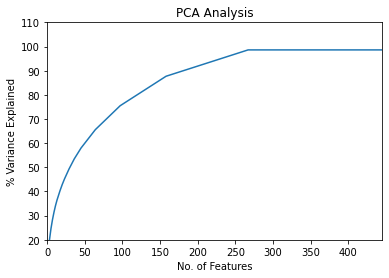

In [ ]:
#Find optimal number of features to reduce to by the number of features that allow us to capture 90% of the data's variance
plot_pca_variance_to_features(len(feature_ids), iter_1_clustering_df[feature_ids])

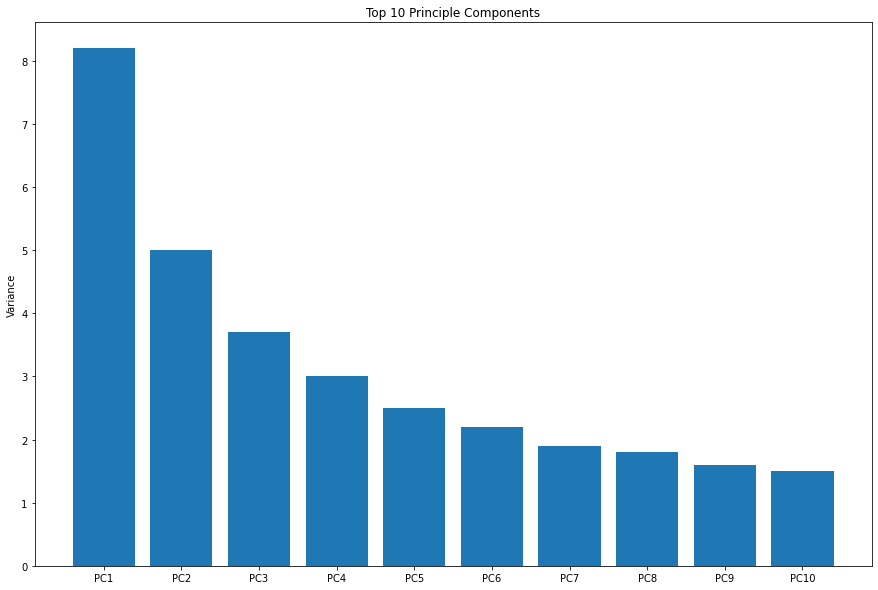

In [ ]:
#From the graph above, we want to use 200 features to keep 90% of the variance
pca = PCA(n_components=200)
data = pca.fit_transform(iter_1_clustering_df[feature_ids])

plt.figure(figsize=(15,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = ['PC'+ str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1)[0:10], height = var[0:10], tick_label = lbls[0:10])
plt.ylabel('Variance')
plt.title('Top 10 Principle Components')
plt.show()

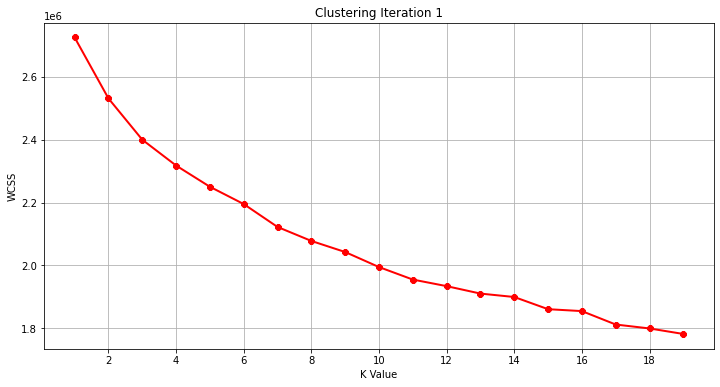

In [ ]:
#Takes a while to run
plot_elbow_curve(iter_1_clustering_df[feature_ids], "Clustering Iteration 1") 

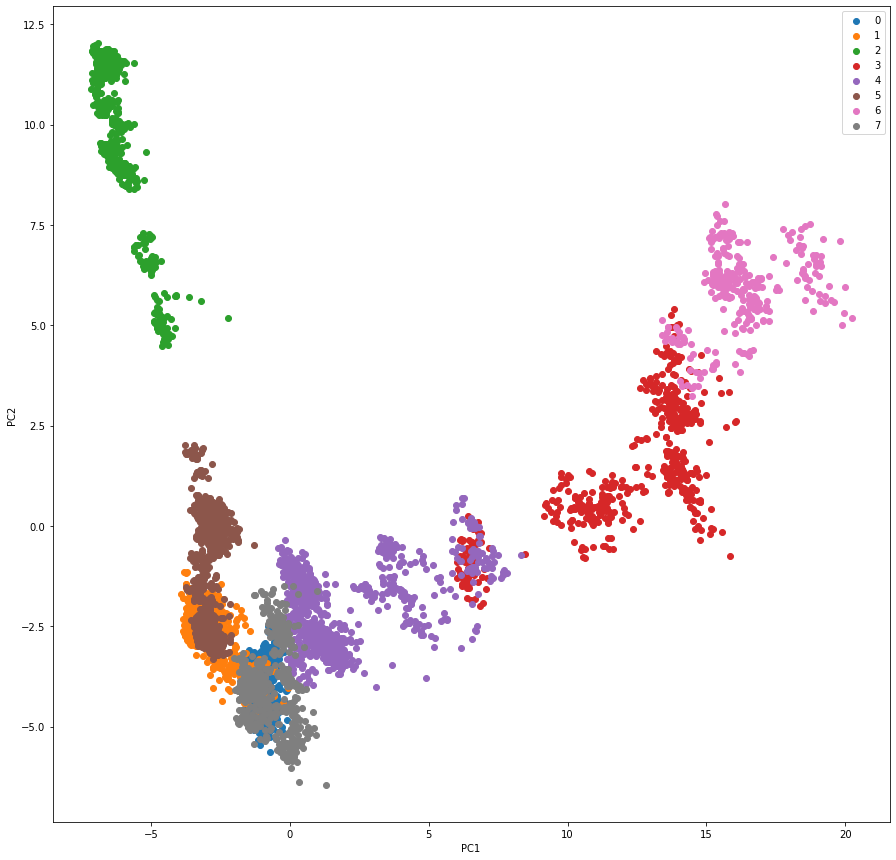

clustering_iter_1
1    1178
2    1144
6     837
3     756
7     670
0     647
4     565
5     314
Name: count, dtype: int64

In [ ]:
kmeans_summary_1 = kmeans_clustering_aves(8, data, average_df, "clustering_iter_1")
kmeans_summary_1["count"]

###Per Cluster Breakdown



PERSONA CLUSTER: 0 

NUMBER OF USERS IN CLUSTER: 647.0 

PERCENTAGE OF USERS IN CLUSTER: 10.587 



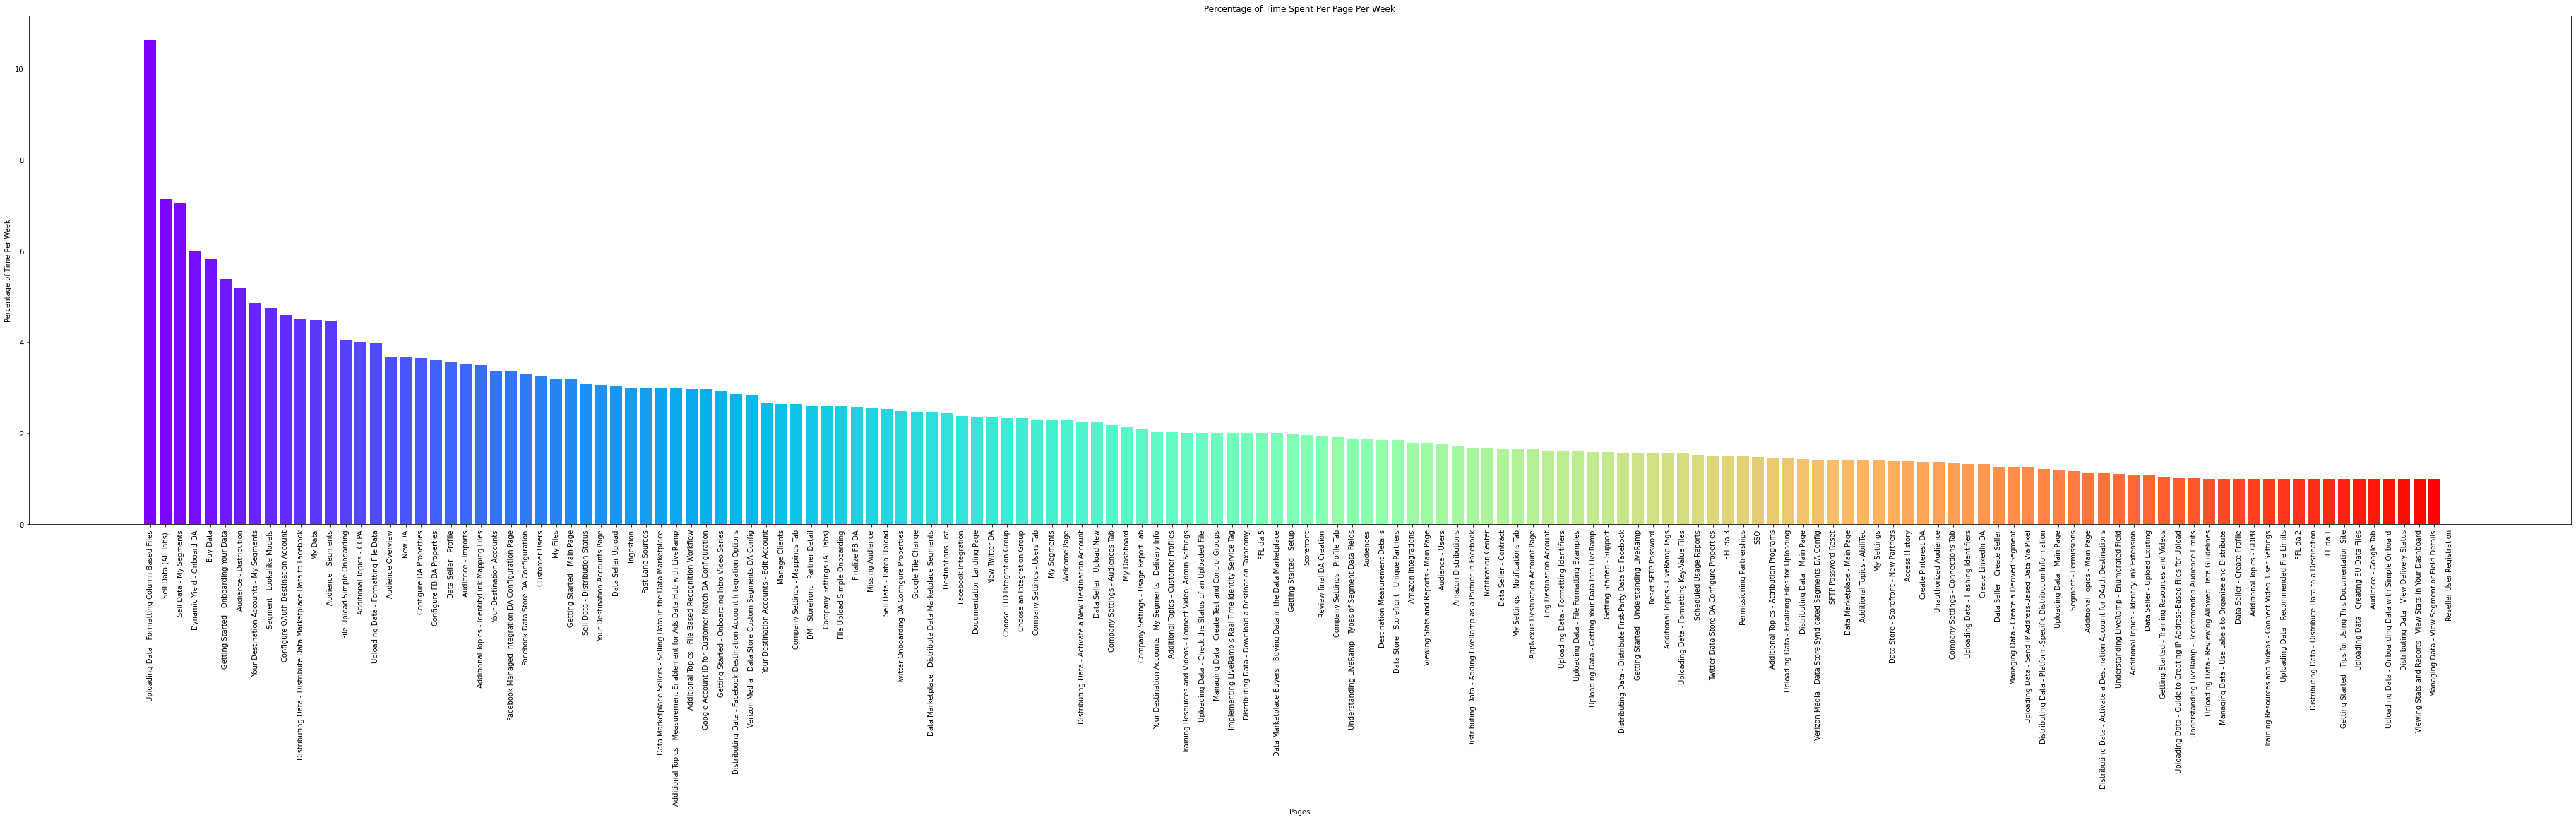

<Figure size 432x288 with 0 Axes>

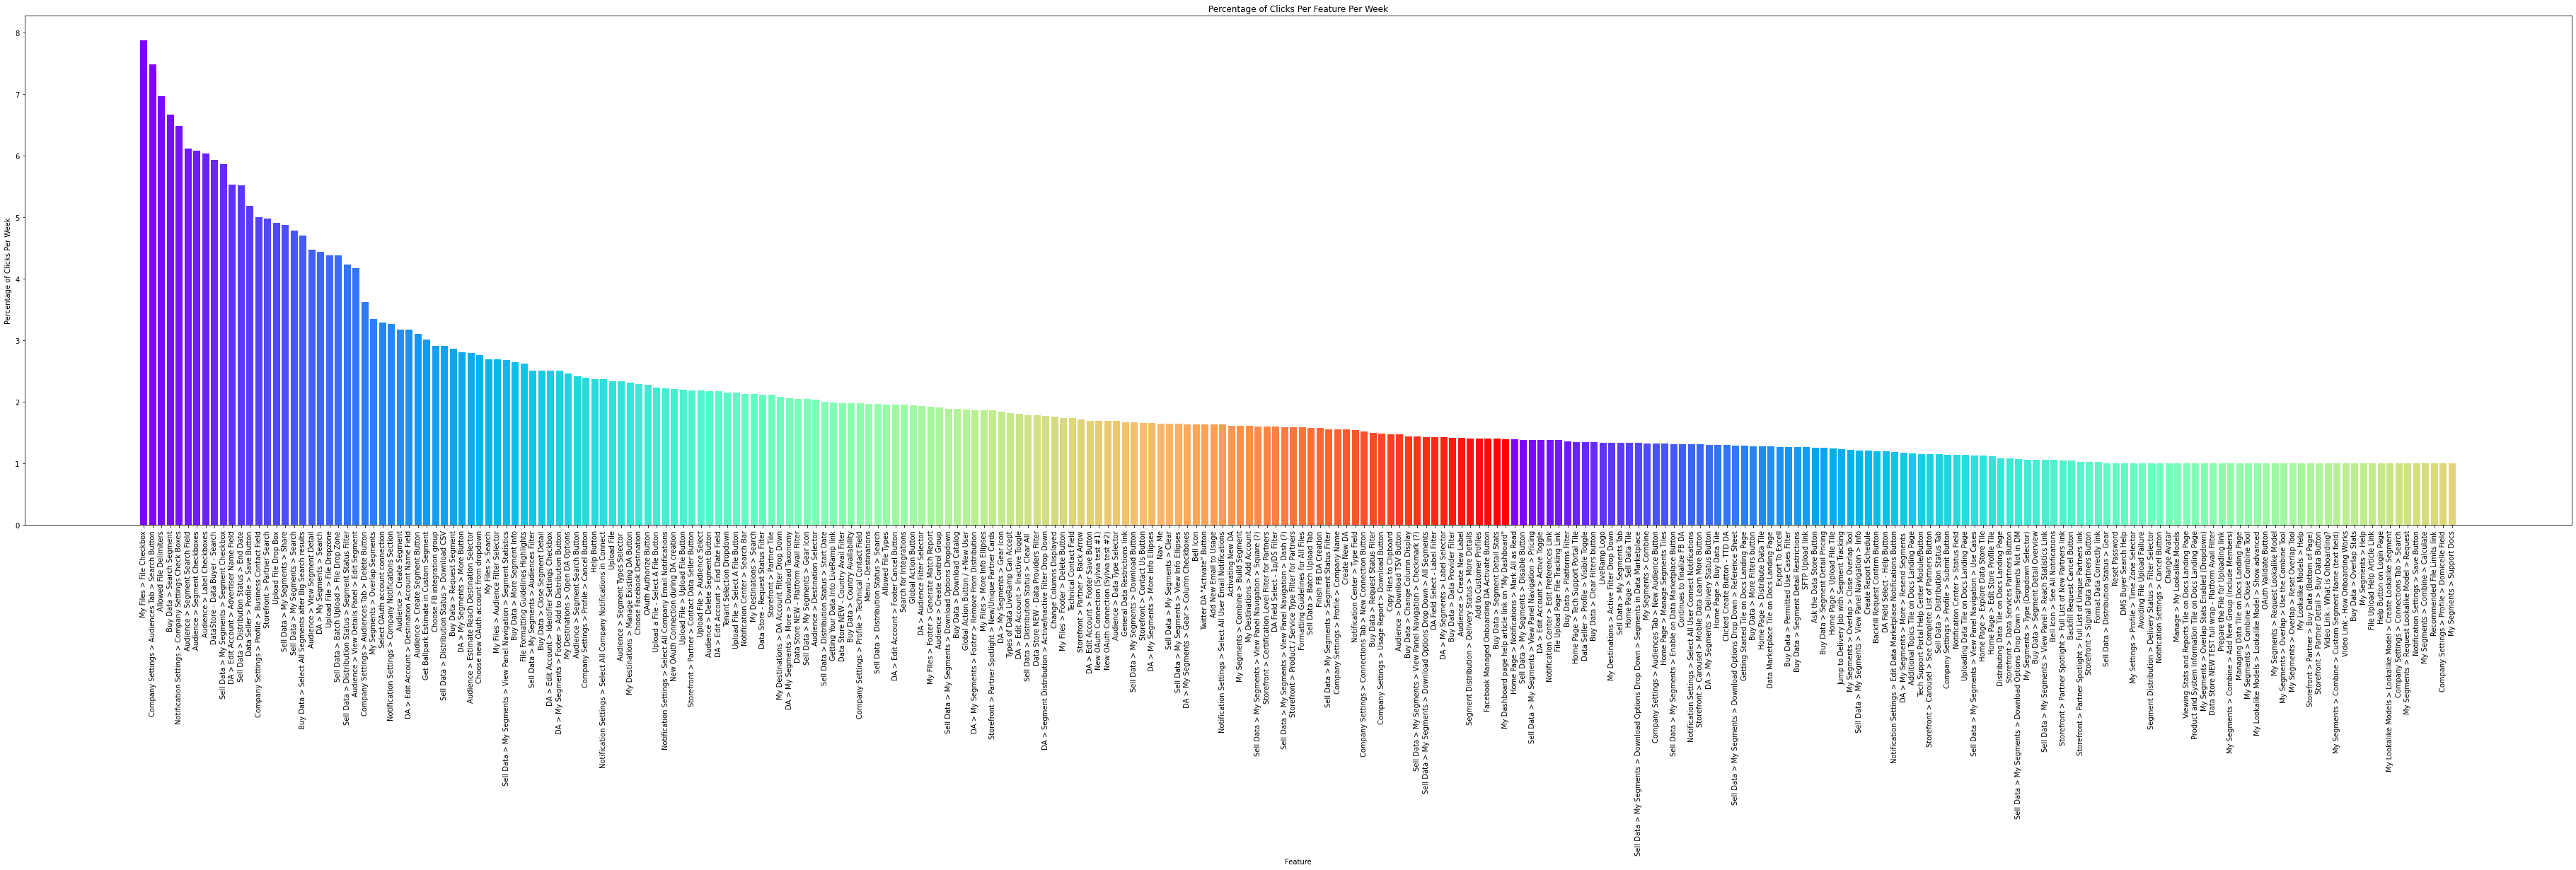

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Uploading Data - Formatting Column-Based Files 
 10.622102 
 
 
 Sell Data (All Tabs) 
 7.131249 
 
 
 Sell Data - My Segments 
 7.034143 
 
 
 Dynamic Yield - Onboard DA 
 6.000000 
 
 
 Buy Data 
 5.831984 
 
 
 Getting Started - Onboarding Your Data 
 5.377125 
 
 
 Audience - Distribution 
 5.179388 
 
 
 Your Destination Accounts - My Segments 
 4.853074 
 
 
 
 
 
 
 feature 
 
 
 
 
 My Files > File Checkbox 
 7.876897 
 
 
 Company Settings > Audiences Tab > Search Button 
 7.487166 
 
 
 Allowed File Delimiters 
 6.961360 
 
 
 Buy Data > Search Segment 
 6.666821 
 
 
 Notification Settings > Company Settings Check Boxes 
 6.485317 
 
 
 Audience > Segment Search Field 
 6.119848 
 
 
 Audience > Segment Checkboxes 
 6.081260 
 
 
 Audience > Label Checkboxes 
 6.031534

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 0)



PERSONA CLUSTER: 1 

NUMBER OF USERS IN CLUSTER: 1178.0 

PERCENTAGE OF USERS IN CLUSTER: 19.277 



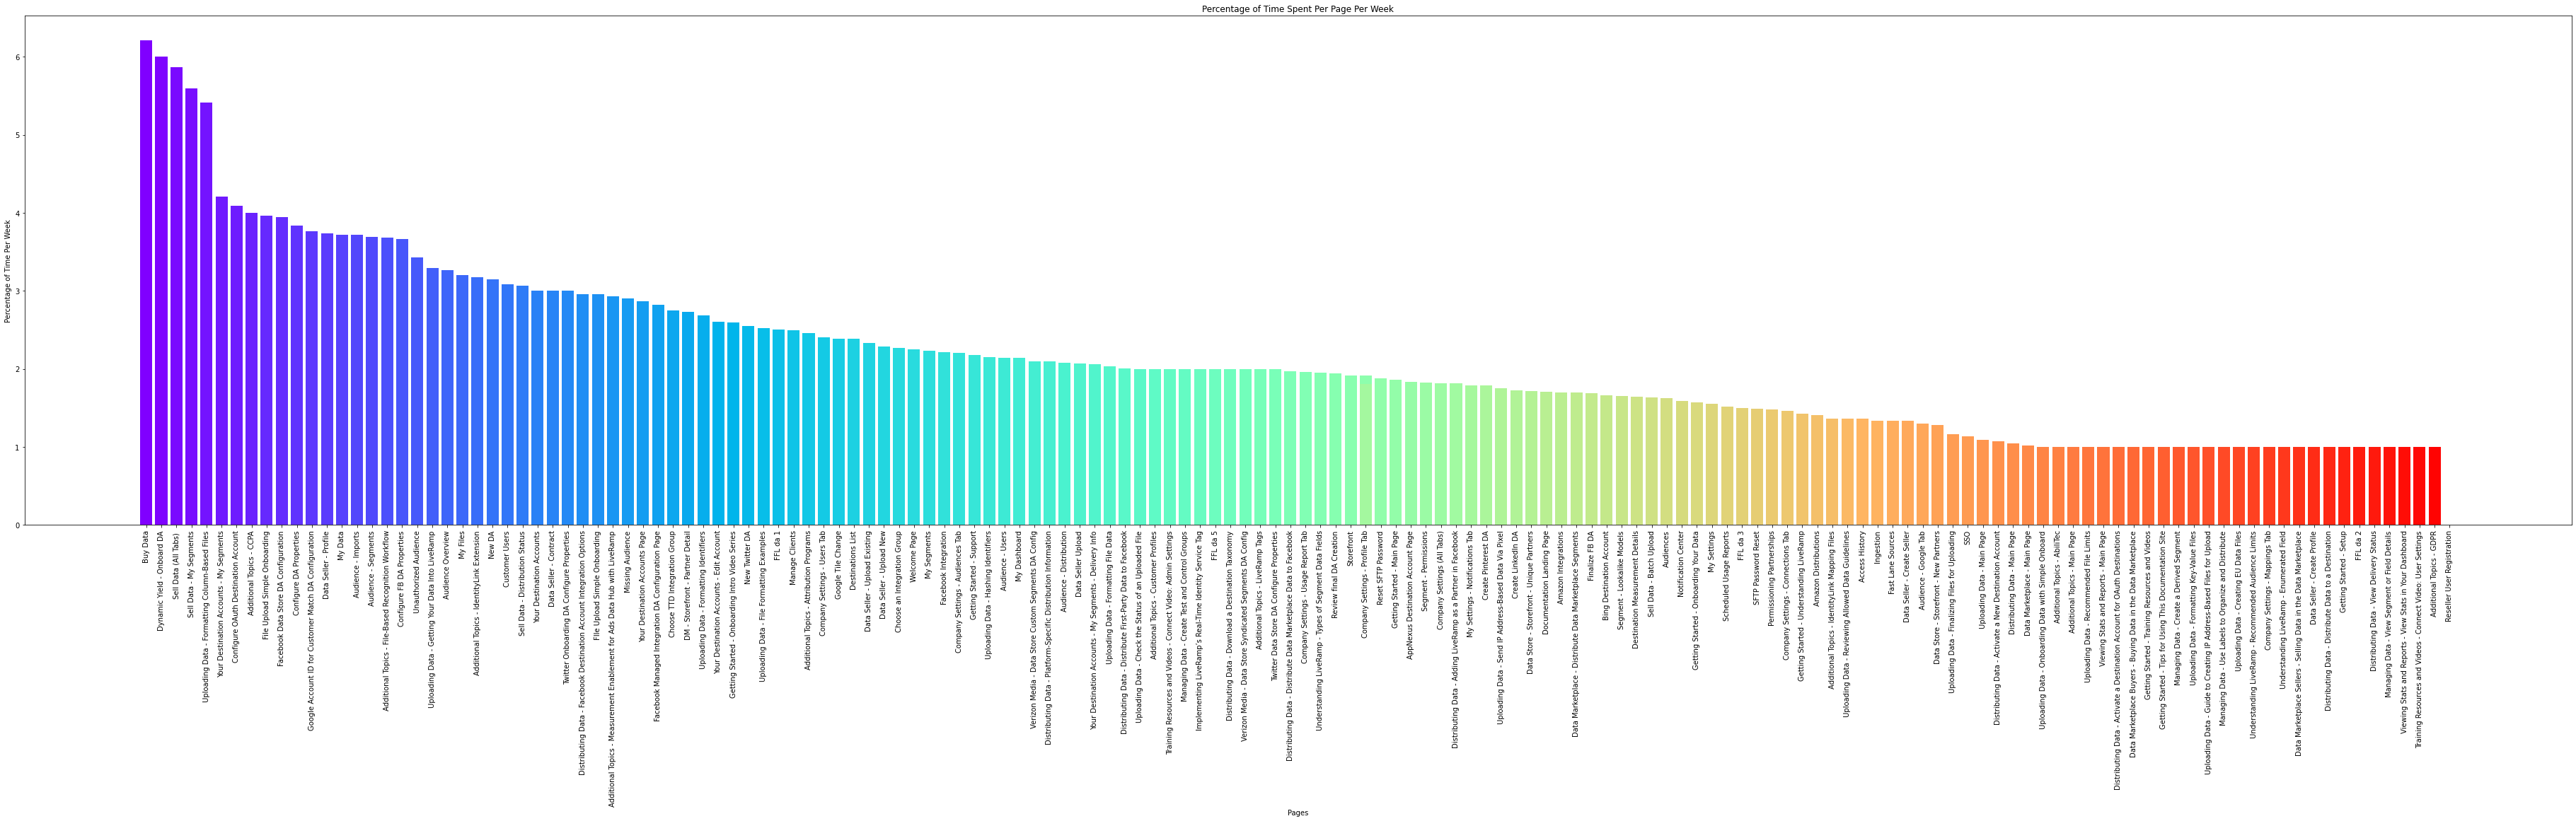

<Figure size 432x288 with 0 Axes>

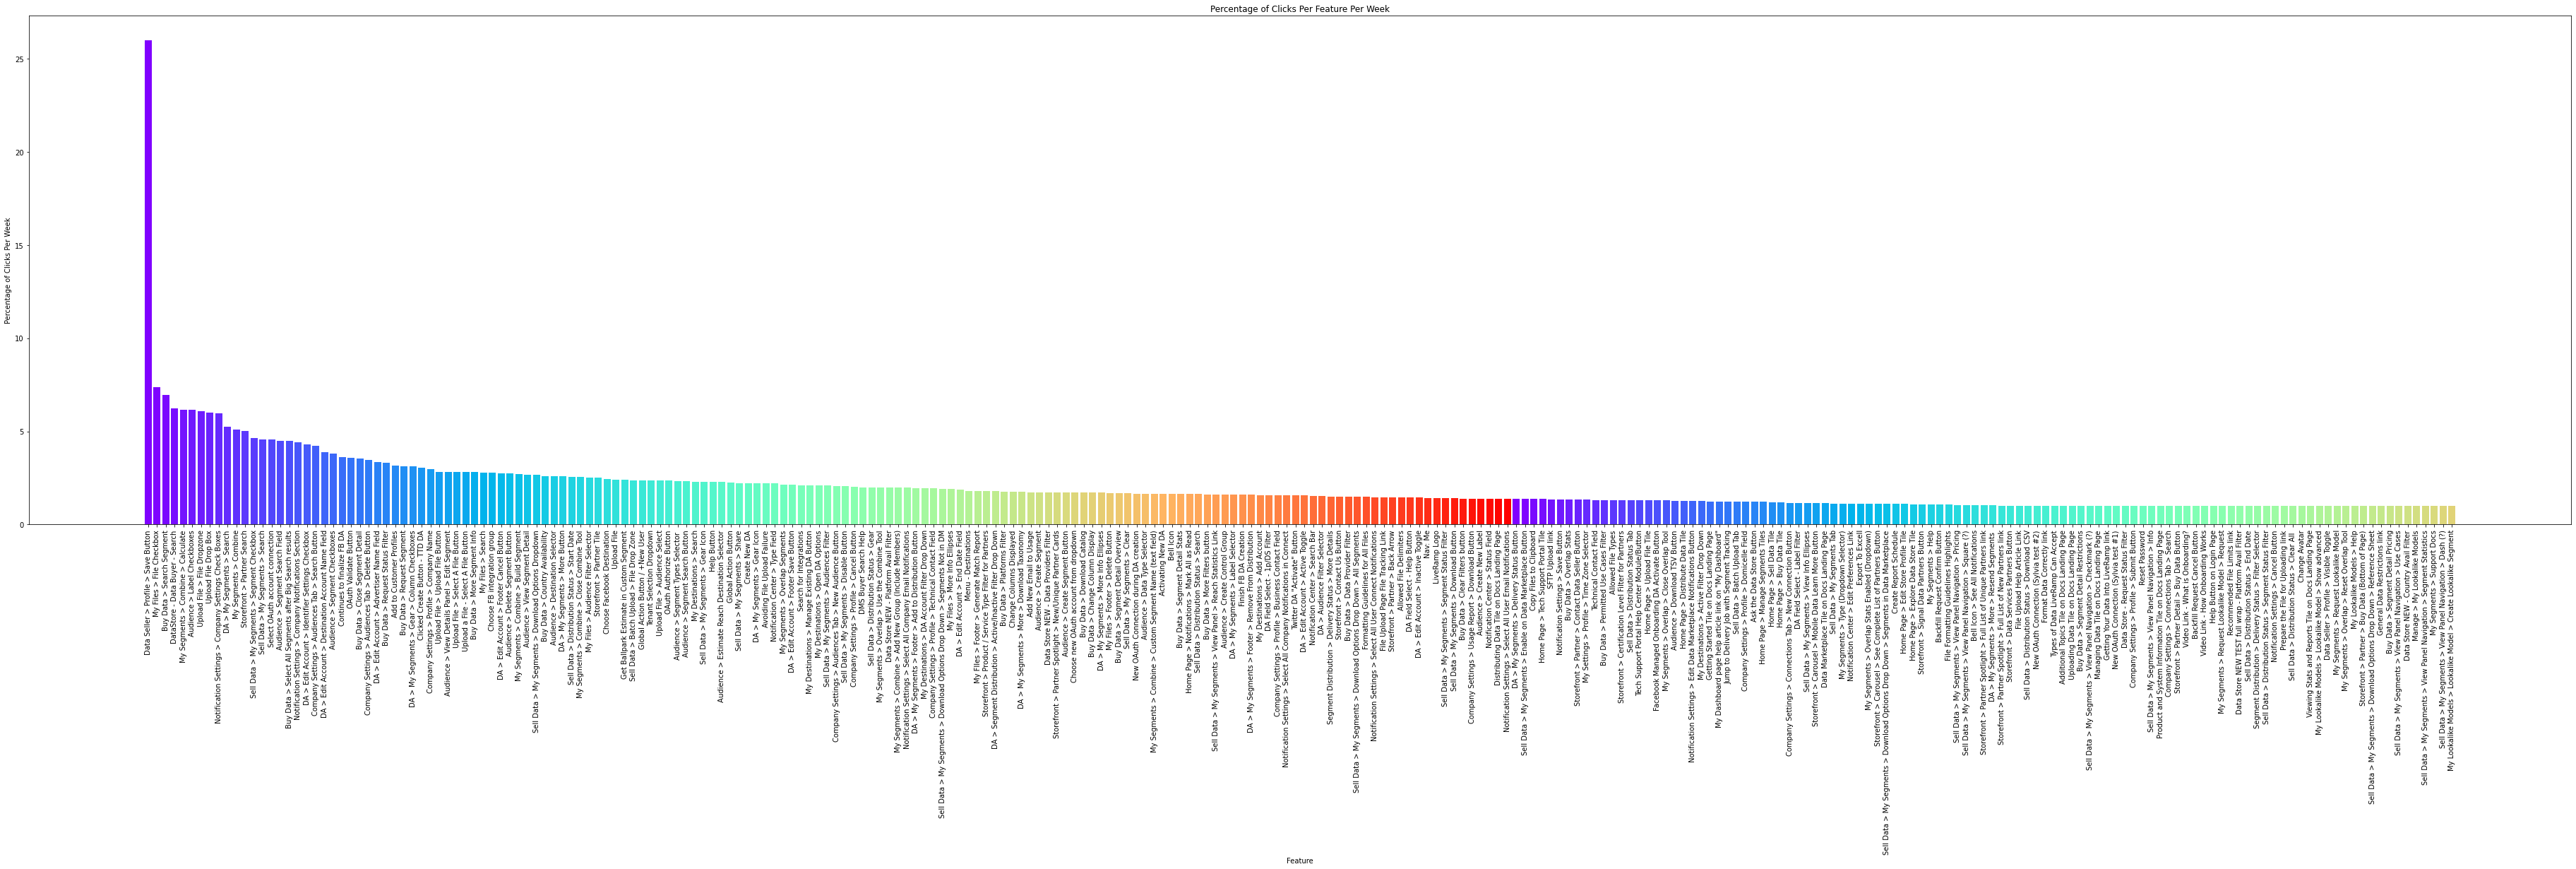

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Buy Data 
 6.212650 
 
 
 Dynamic Yield - Onboard DA 
 6.000000 
 
 
 Sell Data (All Tabs) 
 5.866323 
 
 
 Sell Data - My Segments 
 5.590707 
 
 
 Uploading Data - Formatting Column-Based Files 
 5.409168 
 
 
 Your Destination Accounts - My Segments 
 4.208501 
 
 
 Configure OAuth Destination Account 
 4.087842 
 
 
 Additional Topics - CCPA 
 4.000000 
 
 
 
 
 
 
 feature 
 
 
 
 
 Data Seller > Profile > Save Button 
 26.000000 
 
 
 My Files > File Checkbox 
 7.388390 
 
 
 Buy Data > Search Segment 
 6.951971 
 
 
 DataStore - Data Buyer - Search 
 6.217028 
 
 
 My Segments > Combine > Calculate 
 6.169779 
 
 
 Audience > Label Checkboxes 
 6.144942 
 
 
 Upload File > File Dropzone 
 6.084414 
 
 
 Upload File Drop Box 
 6.001422

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 1)



PERSONA CLUSTER: 2 

NUMBER OF USERS IN CLUSTER: 1144.0 

PERCENTAGE OF USERS IN CLUSTER: 18.72 



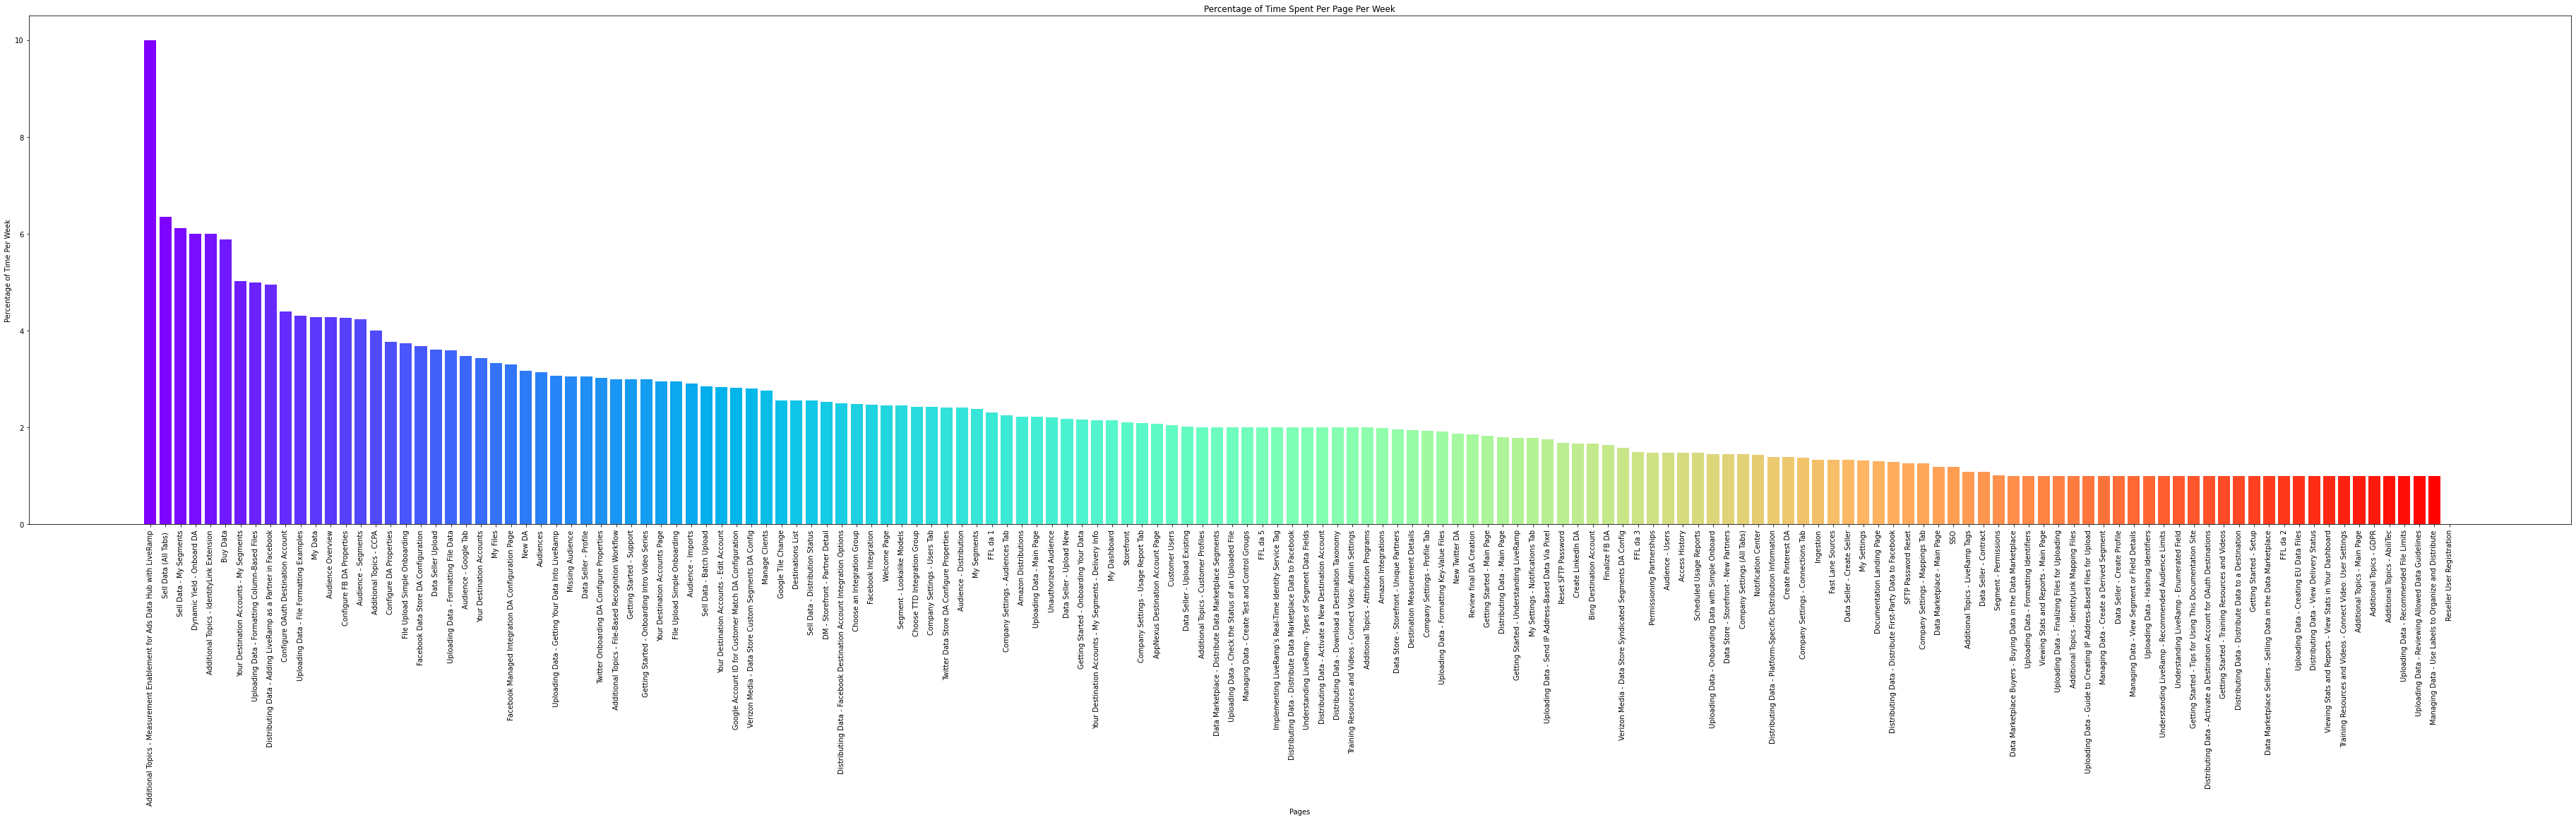

<Figure size 432x288 with 0 Axes>

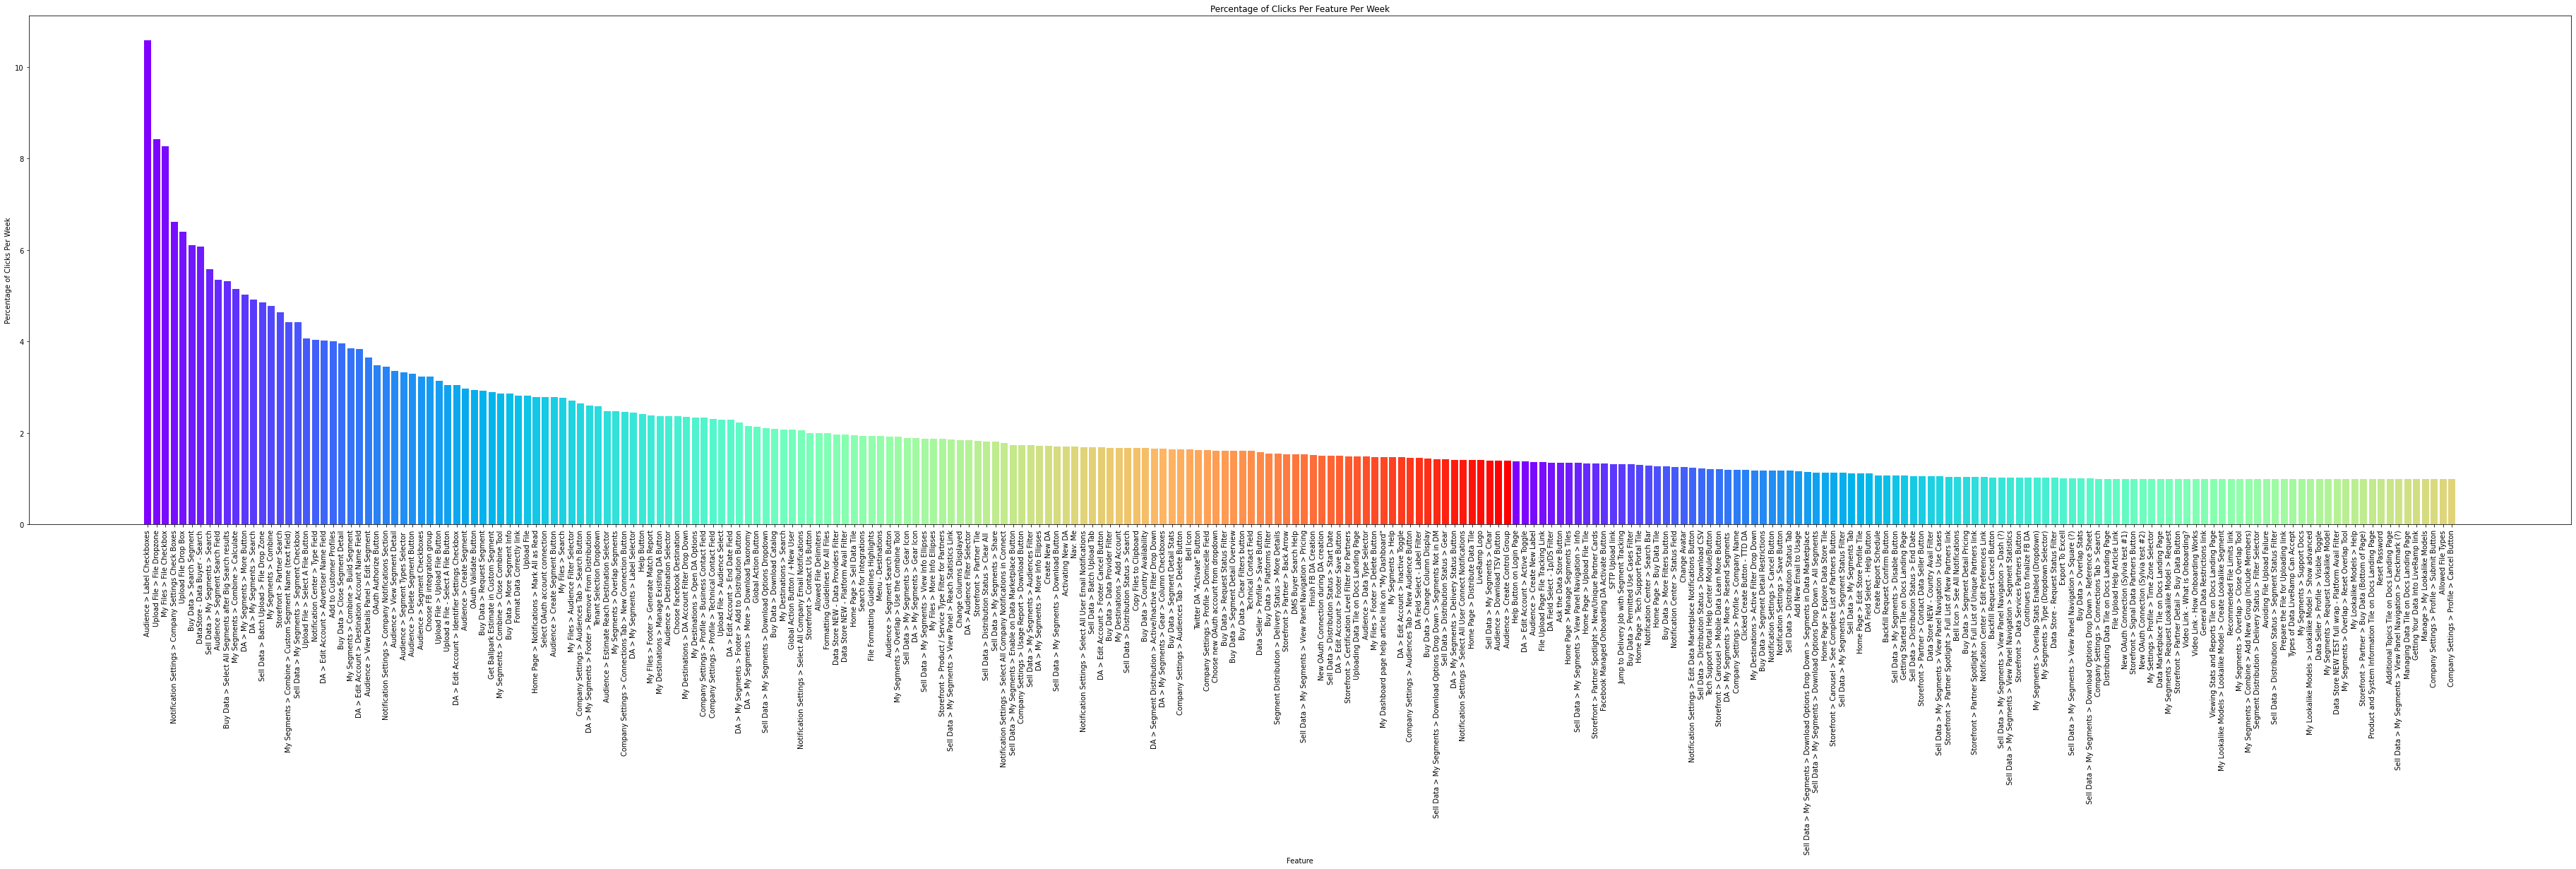

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Additional Topics - Measurement Enablement for Ads Data Hub with LiveRamp 
 10.000000 
 
 
 Sell Data (All Tabs) 
 6.347583 
 
 
 Sell Data - My Segments 
 6.111643 
 
 
 Dynamic Yield - Onboard DA 
 6.000000 
 
 
 Additional Topics - IdentityLink Extension 
 6.000000 
 
 
 Buy Data 
 5.883305 
 
 
 Your Destination Accounts - My Segments 
 5.017784 
 
 
 Uploading Data - Formatting Column-Based Files 
 5.000000 
 
 
 
 
 
 
 feature 
 
 
 
 
 Audience > Label Checkboxes 
 10.587239 
 
 
 Upload File > File Dropzone 
 8.414433 
 
 
 My Files > File Checkbox 
 8.263878 
 
 
 Notification Settings > Company Settings Check Boxes 
 6.608246 
 
 
 Upload File Drop Box 
 6.396645 
 
 
 Buy Data > Search Segment 
 6.100561 
 
 
 DataStore - Data Buyer - Search 
 6.071251 
 
 
 Sell Data > My Segments > Search 
 5.574864

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 2)



PERSONA CLUSTER: 3 

NUMBER OF USERS IN CLUSTER: 756.0 

PERCENTAGE OF USERS IN CLUSTER: 12.371 



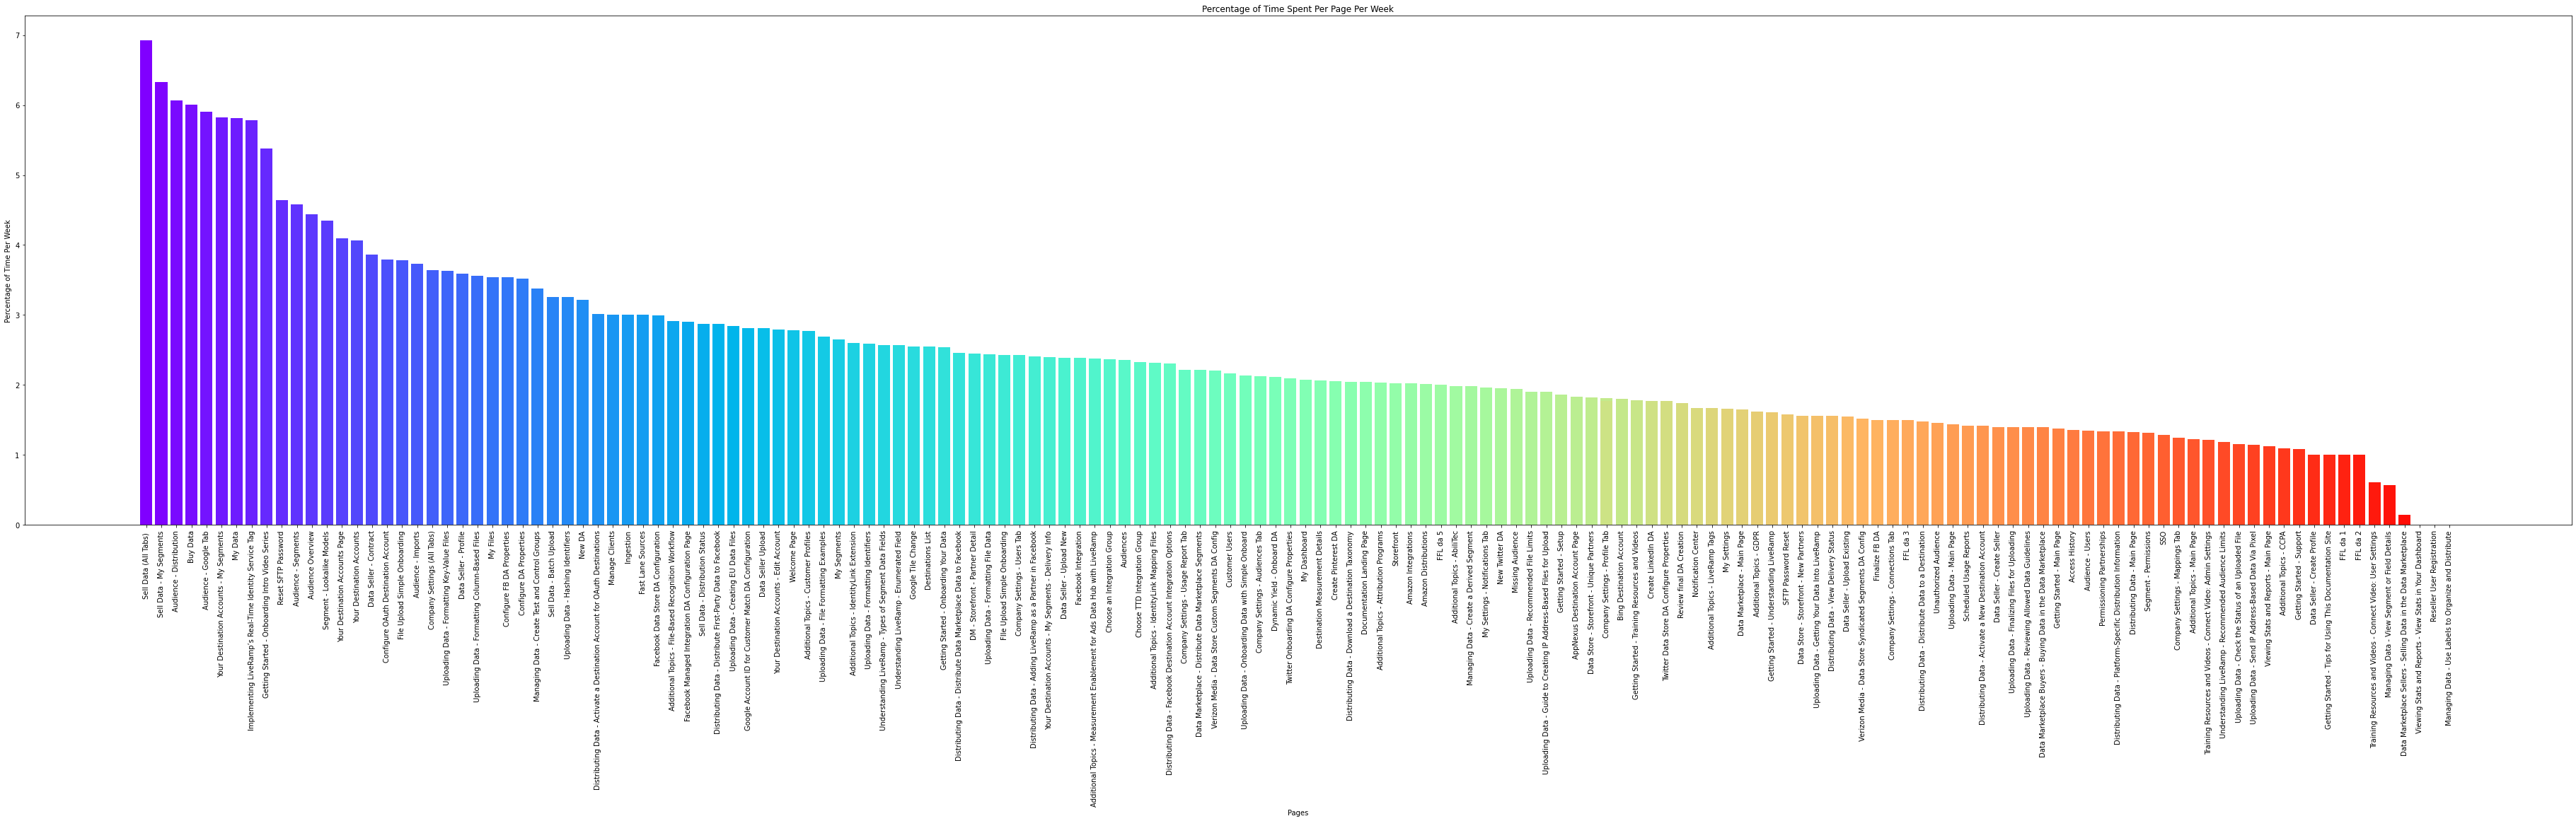

<Figure size 432x288 with 0 Axes>

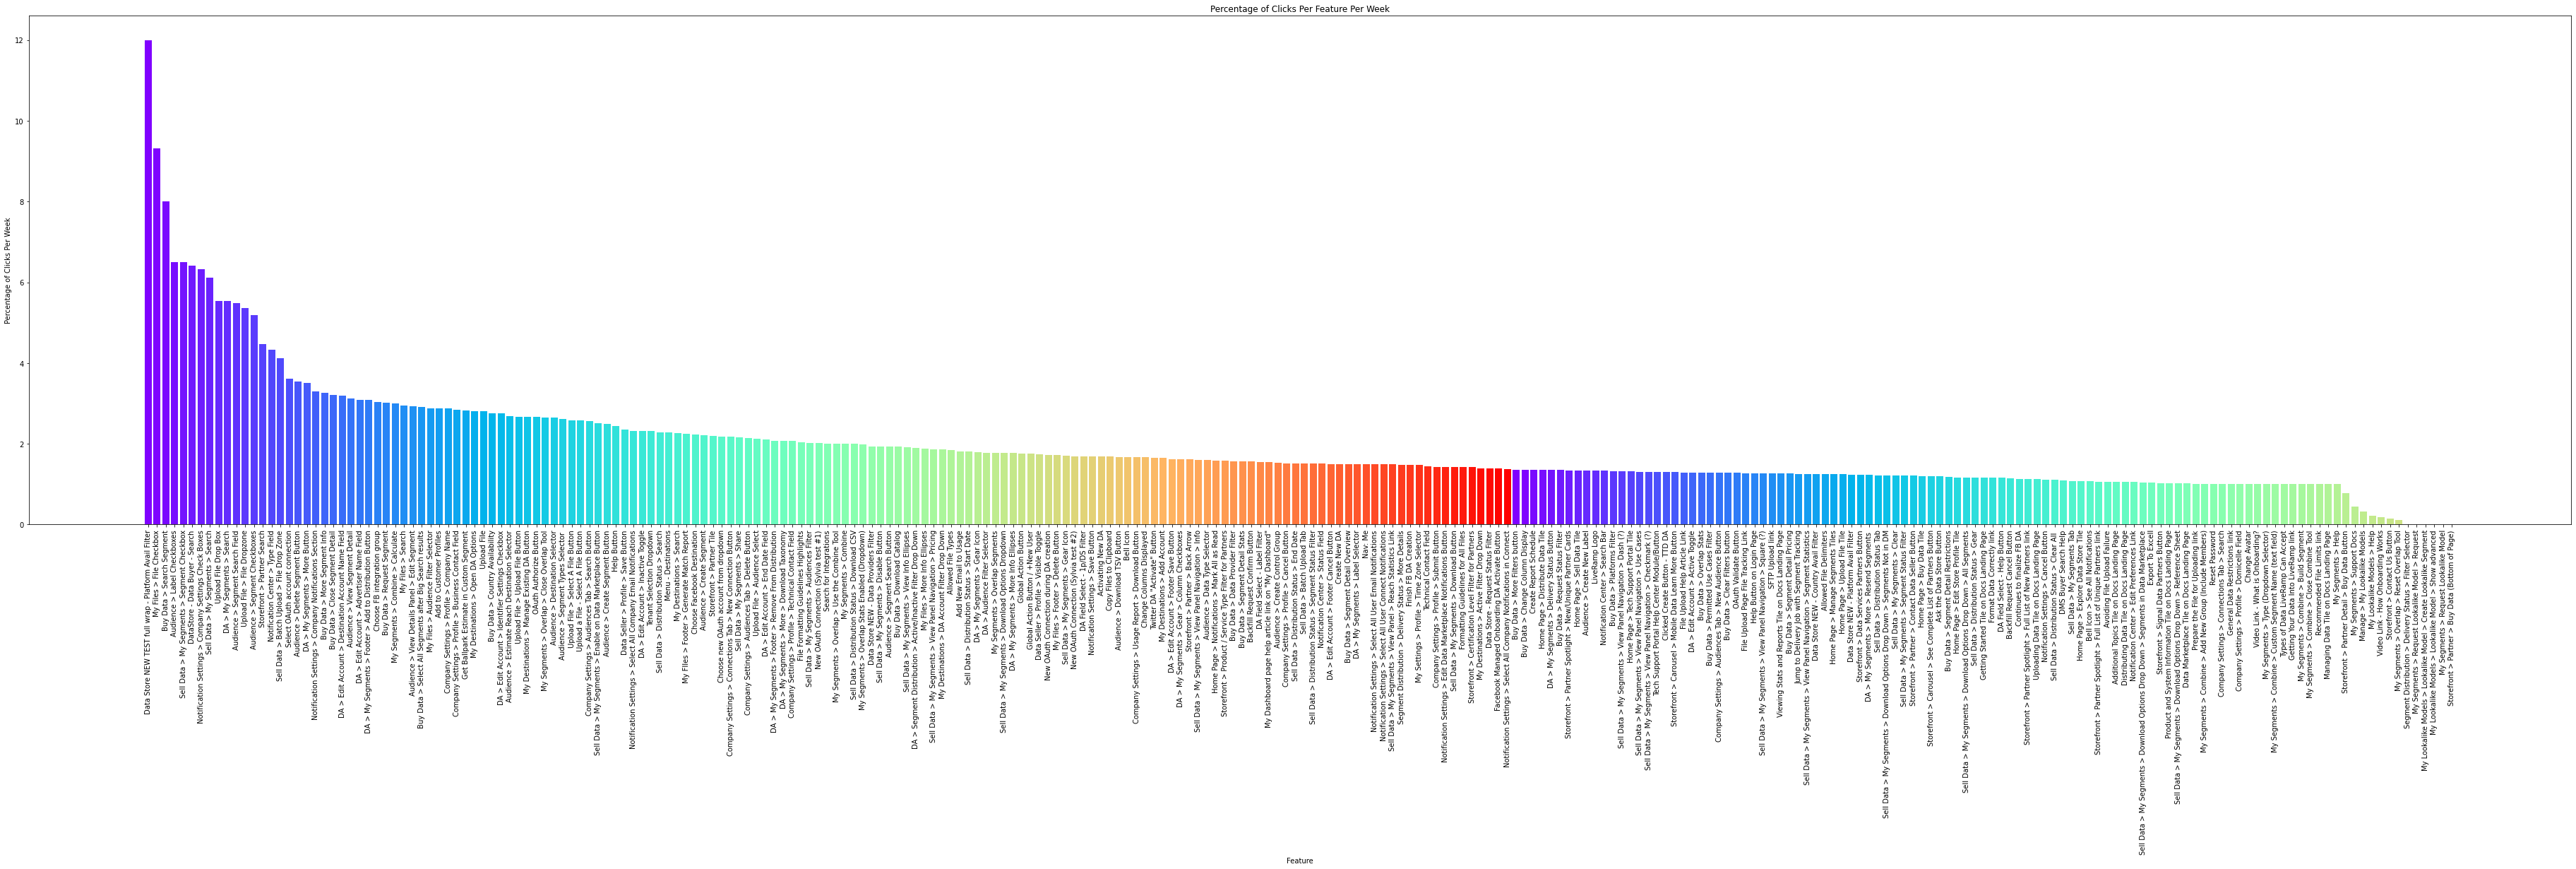

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Sell Data (All Tabs) 
 6.927569 
 
 
 Sell Data - My Segments 
 6.330484 
 
 
 Audience - Distribution 
 6.065196 
 
 
 Buy Data 
 6.005730 
 
 
 Audience - Google Tab 
 5.902447 
 
 
 Your Destination Accounts - My Segments 
 5.818715 
 
 
 My Data 
 5.814995 
 
 
 Implementing LiveRamp’s Real-Time Identity Service Tag 
 5.787037 
 
 
 
 
 
 
 feature 
 
 
 
 
 Data Store NEW TEST full wrap - Platform Avail Filter 
 12.000000 
 
 
 My Files > File Checkbox 
 9.312024 
 
 
 Buy Data > Search Segment 
 8.008011 
 
 
 Audience > Label Checkboxes 
 6.504031 
 
 
 Sell Data > My Segments > Segment Checkbox 
 6.496210 
 
 
 DataStore - Data Buyer - Search 
 6.415207 
 
 
 Notification Settings > Company Settings Check Boxes 
 6.324735 
 
 
 Sell Data > My Segments > Search 
 6.113965

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 3)



PERSONA CLUSTER: 4 

NUMBER OF USERS IN CLUSTER: 565.0 

PERCENTAGE OF USERS IN CLUSTER: 9.246 



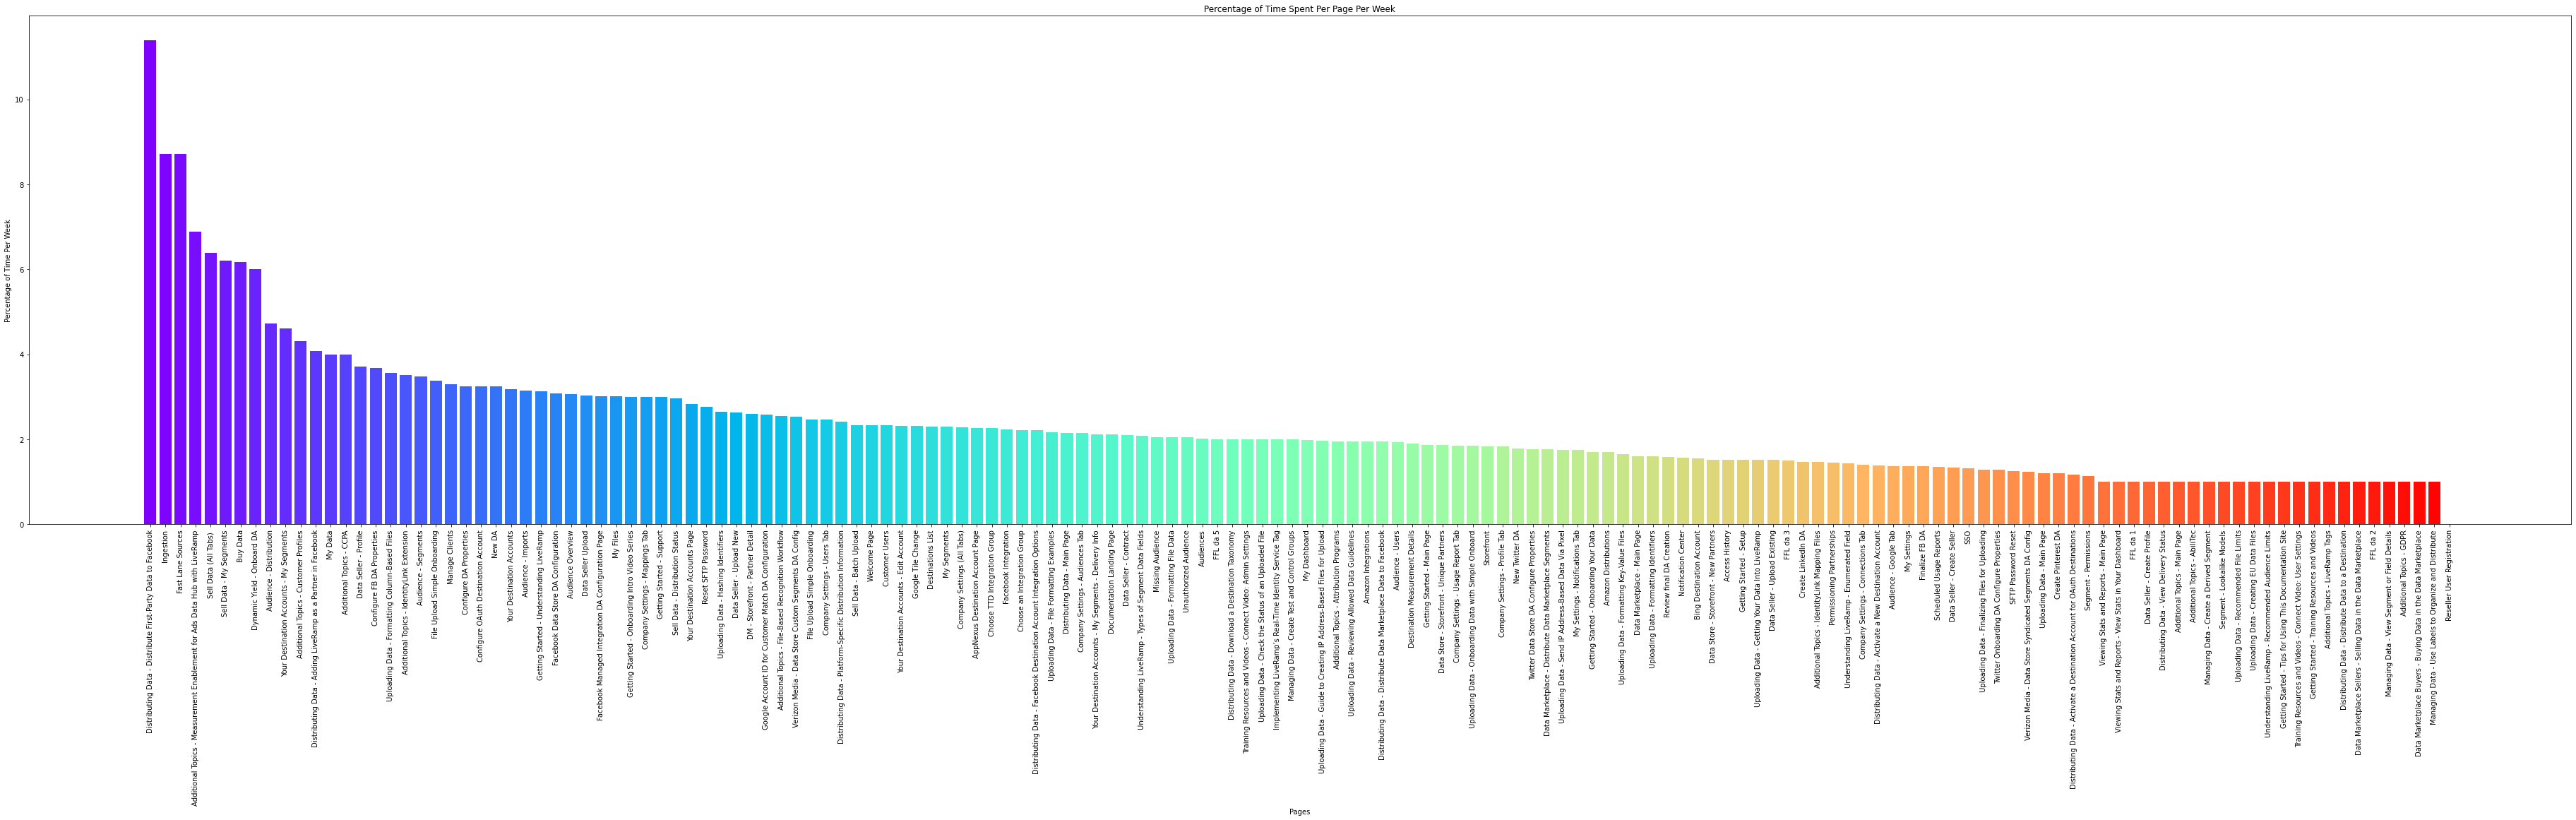

<Figure size 432x288 with 0 Axes>

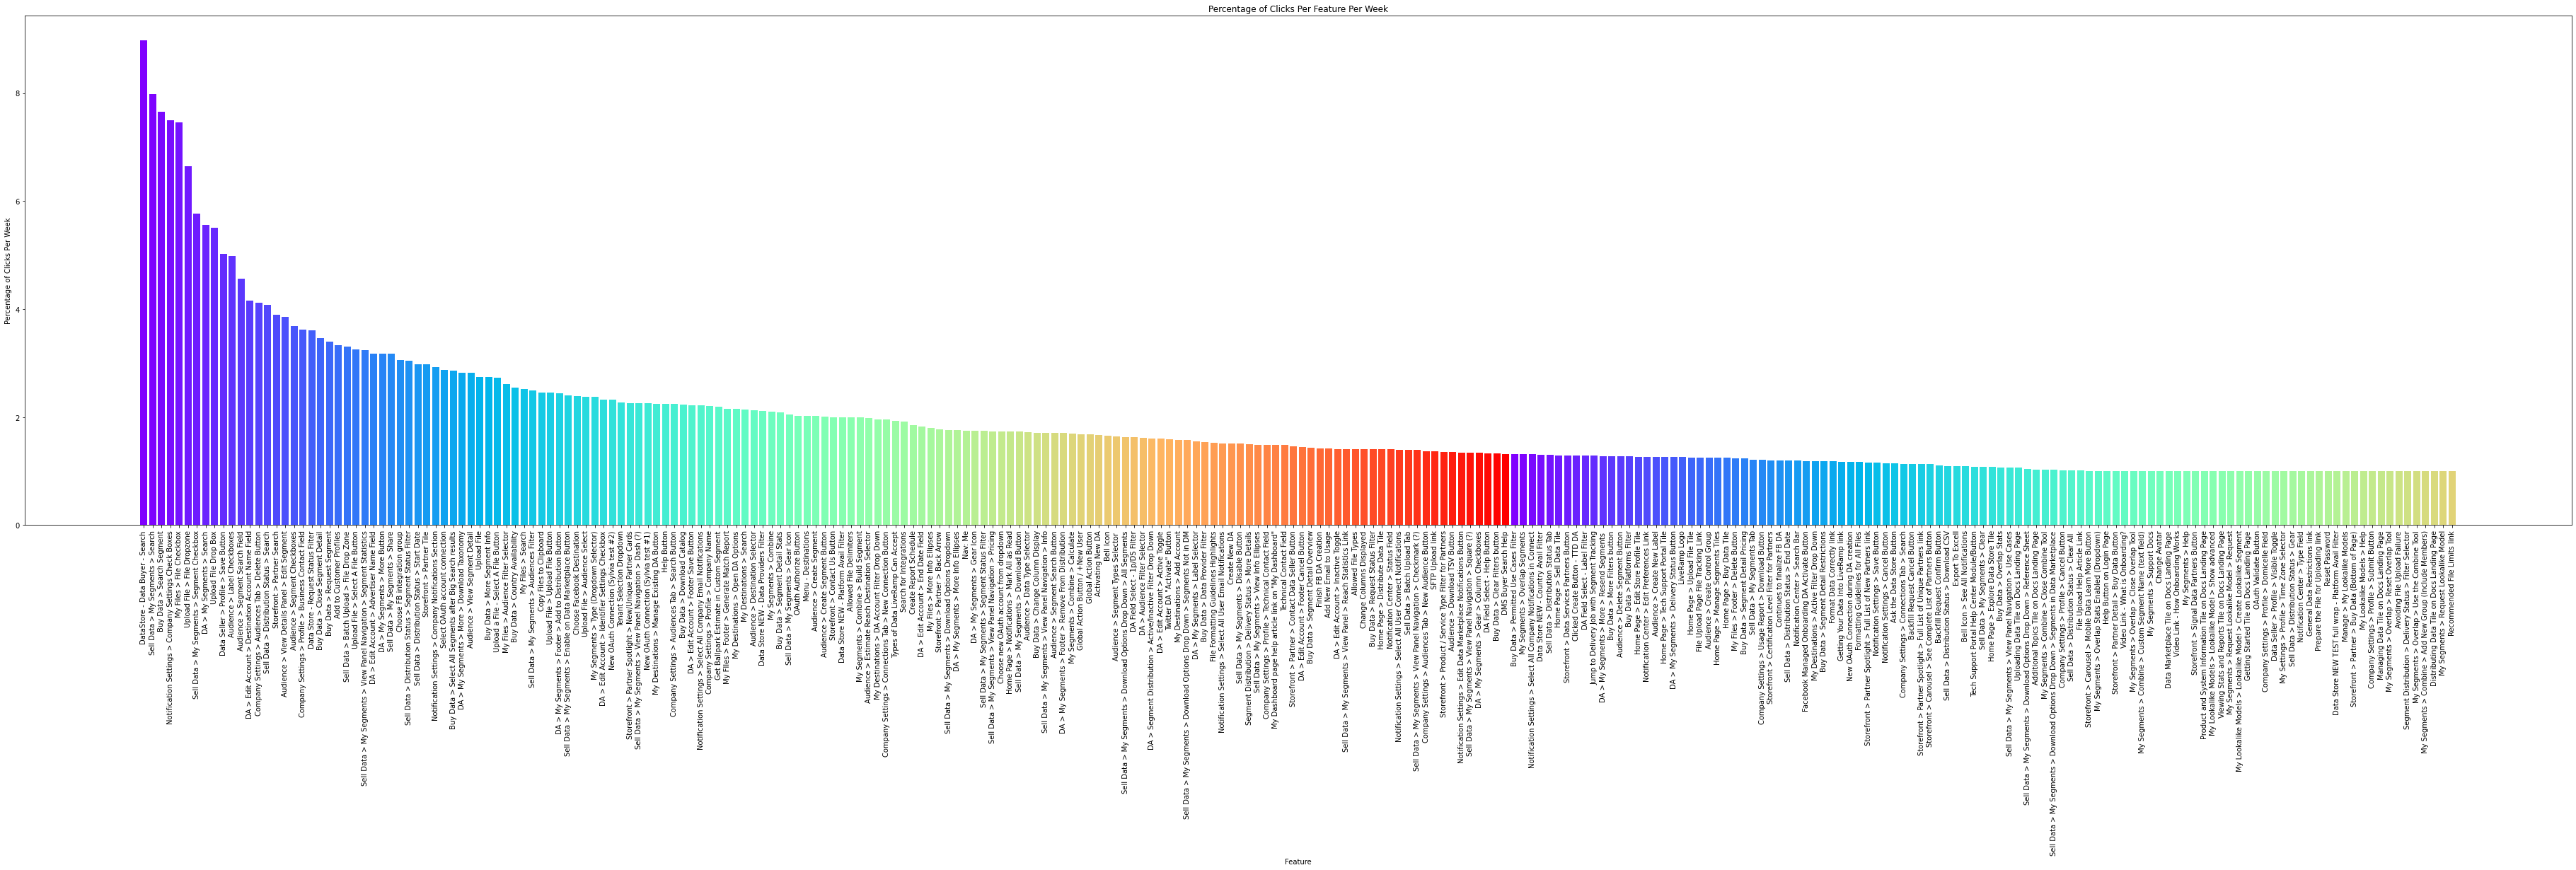

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Distributing Data - Distribute First-Party Data to Facebook 
 11.394690 
 
 
 Ingestion 
 8.720622 
 
 
 Fast Lane Sources 
 8.720622 
 
 
 Additional Topics - Measurement Enablement for Ads Data Hub with LiveRamp 
 6.888496 
 
 
 Sell Data (All Tabs) 
 6.390929 
 
 
 Sell Data - My Segments 
 6.203612 
 
 
 Buy Data 
 6.170405 
 
 
 Dynamic Yield - Onboard DA 
 6.000000 
 
 
 
 
 
 
 feature 
 
 
 
 
 DataStore - Data Buyer - Search 
 8.981709 
 
 
 Sell Data > My Segments > Search 
 7.984397 
 
 
 Buy Data > Search Segment 
 7.654055 
 
 
 Notification Settings > Company Settings Check Boxes 
 7.498230 
 
 
 My Files > File Checkbox 
 7.456770 
 
 
 Upload File > File Dropzone 
 6.646548 
 
 
 Sell Data > My Segments > Segment Checkbox 
 5.764489 
 
 
 DA > My Segments > Search 
 5.555182

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 4)



PERSONA CLUSTER: 5 

NUMBER OF USERS IN CLUSTER: 314.0 

PERCENTAGE OF USERS IN CLUSTER: 5.138 



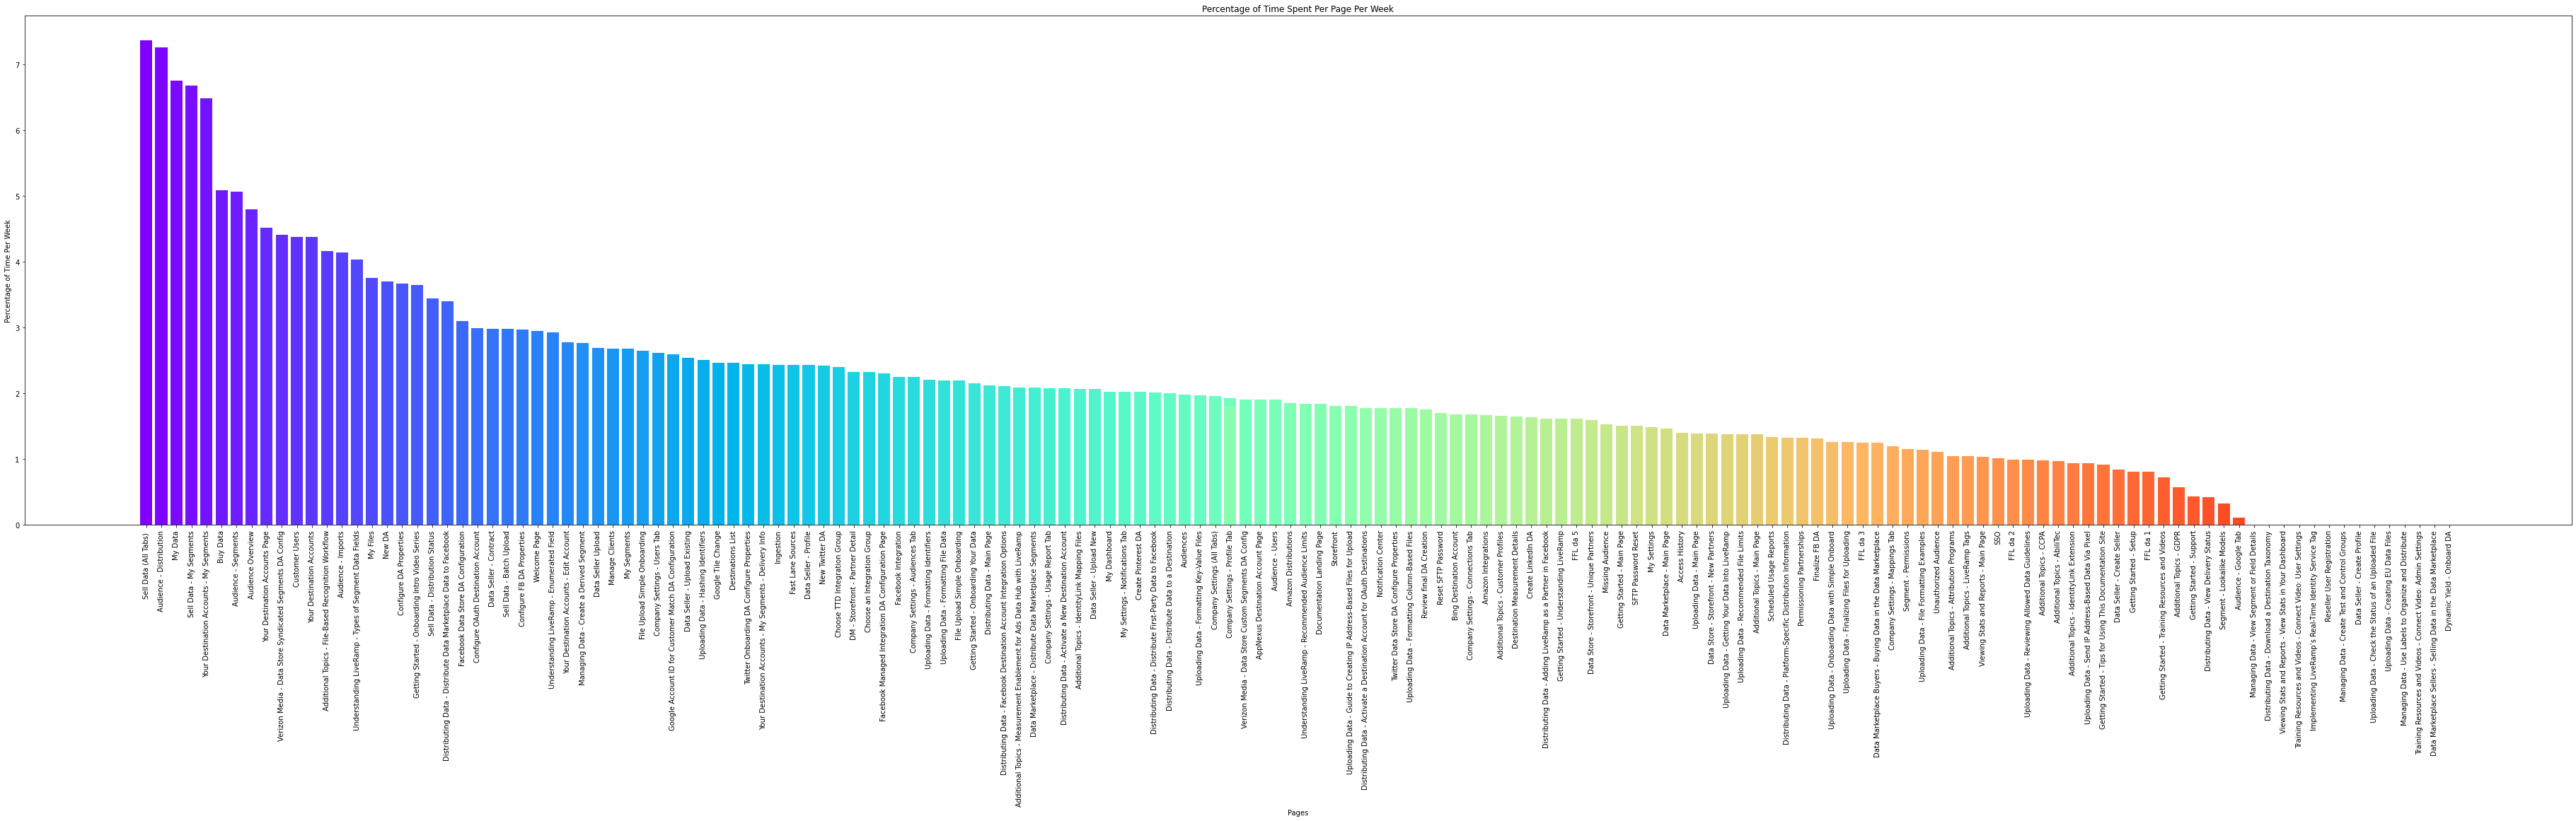

<Figure size 432x288 with 0 Axes>

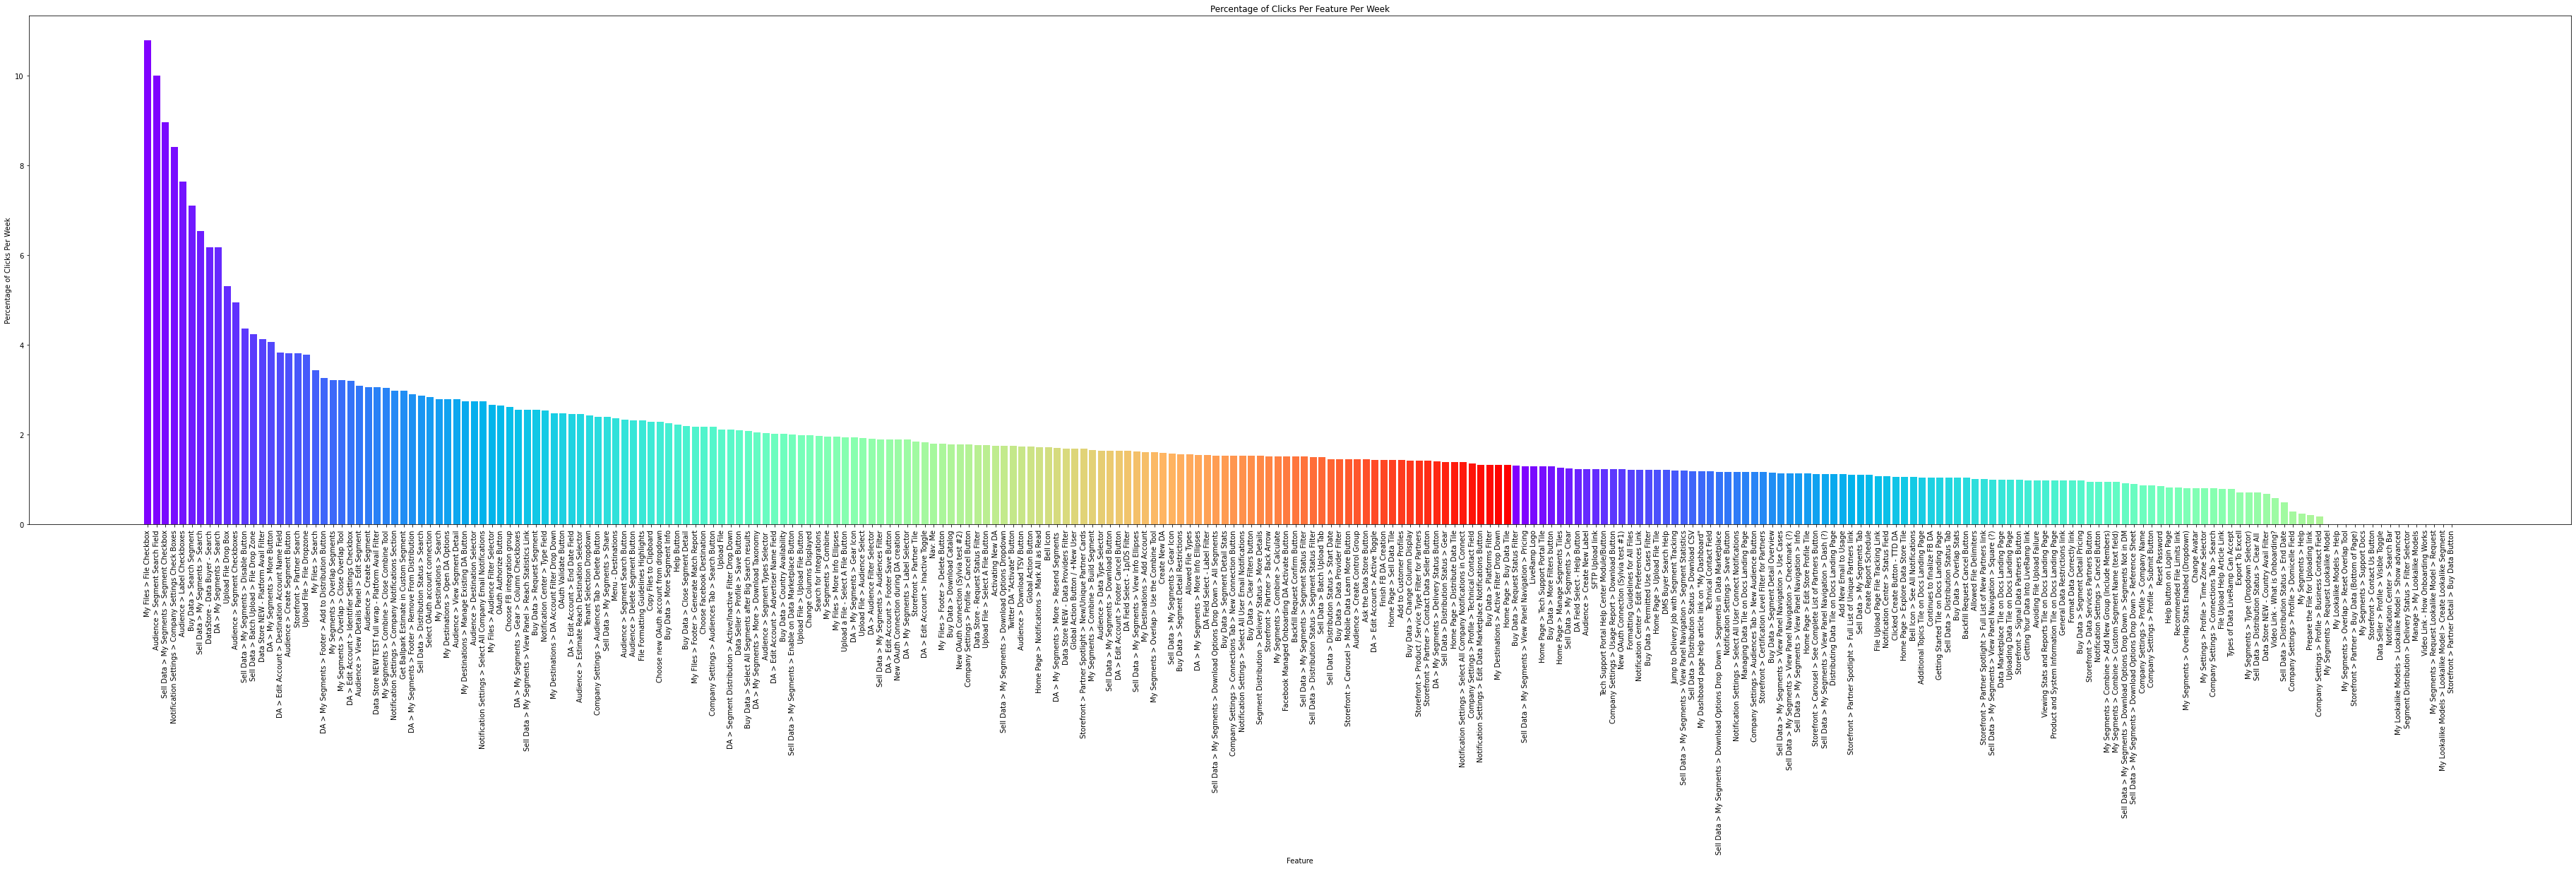

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Sell Data (All Tabs) 
 7.369726 
 
 
 Audience - Distribution 
 7.254997 
 
 
 My Data 
 6.751322 
 
 
 Sell Data - My Segments 
 6.678404 
 
 
 Your Destination Accounts - My Segments 
 6.483524 
 
 
 Buy Data 
 5.084603 
 
 
 Audience - Segments 
 5.069063 
 
 
 Audience Overview 
 4.801626 
 
 
 
 
 
 
 feature 
 
 
 
 
 My Files > File Checkbox 
 10.795261 
 
 
 Audience > Segment Search Field 
 10.007643 
 
 
 Sell Data > My Segments > Segment Checkbox 
 8.964764 
 
 
 Notification Settings > Company Settings Check Boxes 
 8.419851 
 
 
 Audience > Label Checkboxes 
 7.634340 
 
 
 Buy Data > Search Segment 
 7.112217 
 
 
 Sell Data > My Segments > Search 
 6.546029 
 
 
 DataStore - Data Buyer - Search 
 6.179996

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 5)



PERSONA CLUSTER: 6 

NUMBER OF USERS IN CLUSTER: 837.0 

PERCENTAGE OF USERS IN CLUSTER: 13.697 



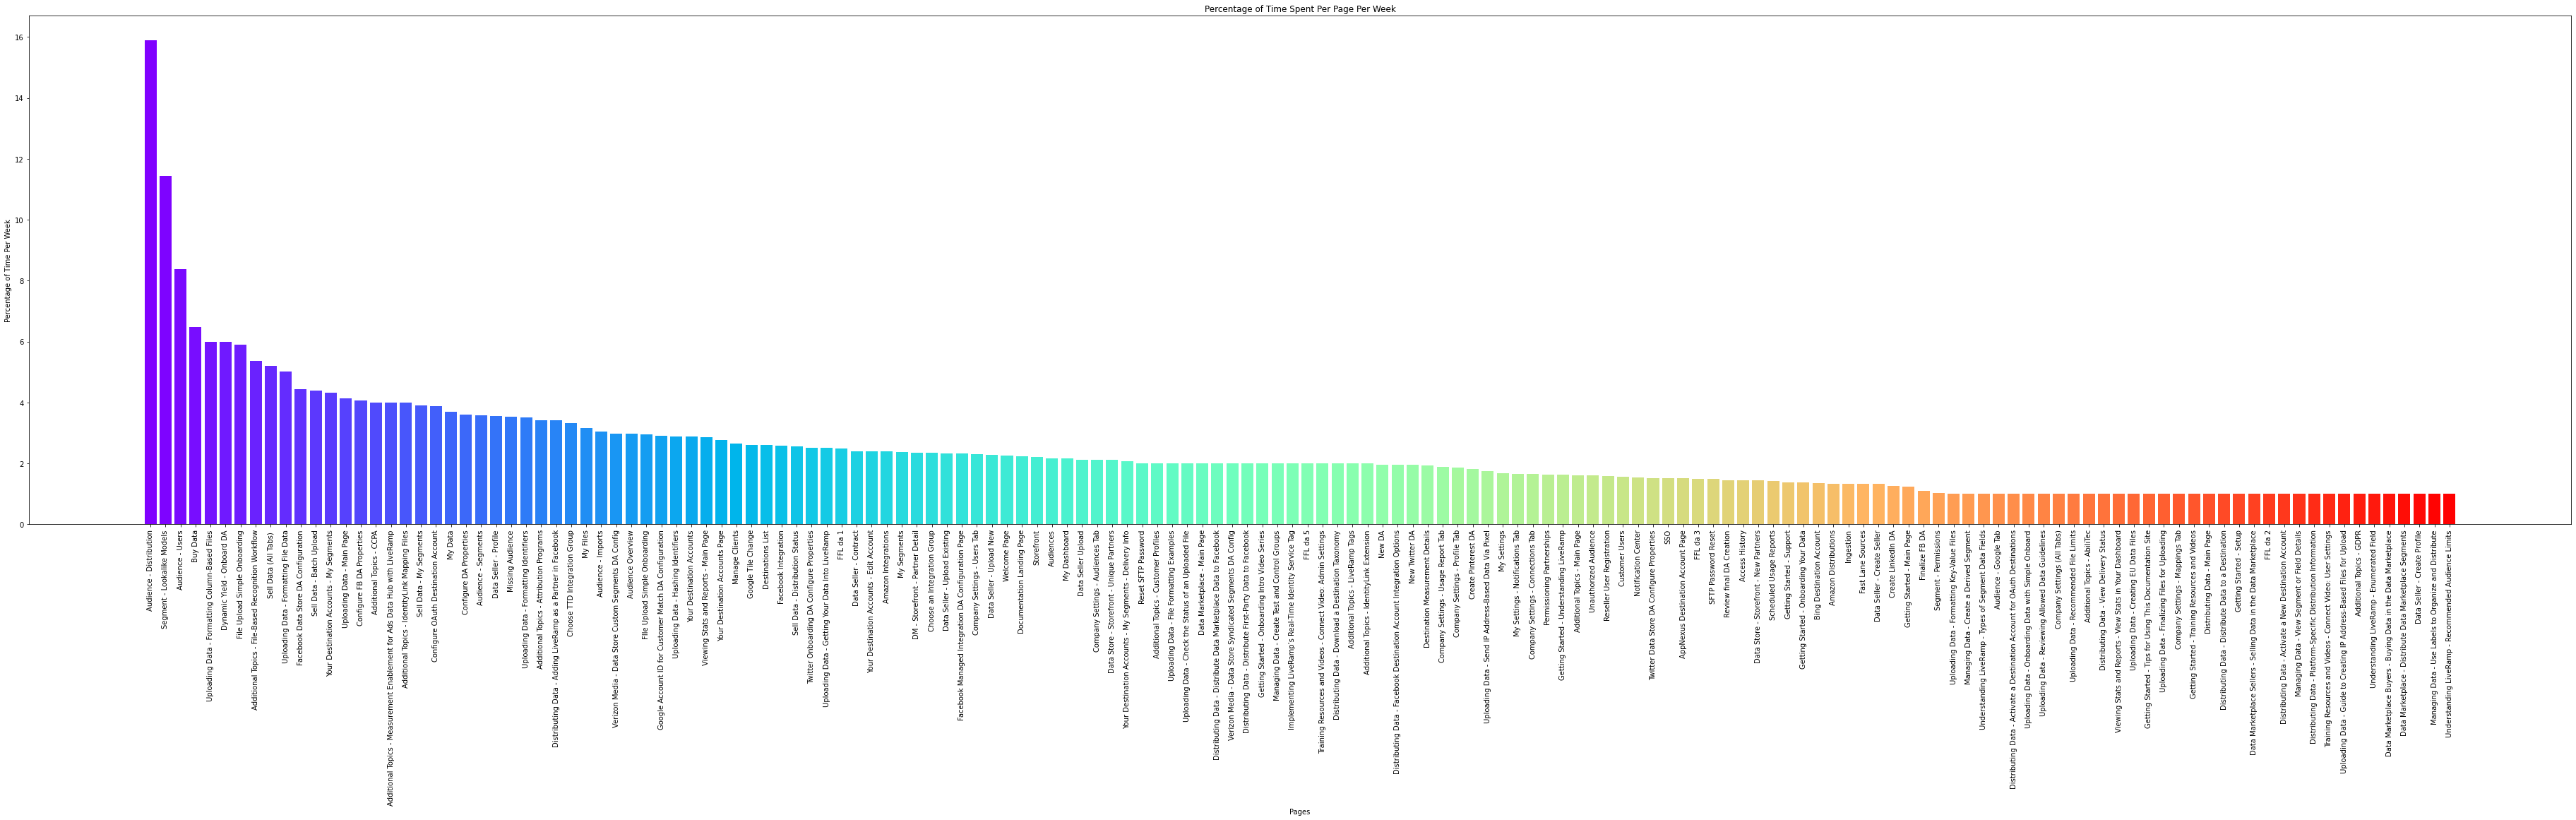

<Figure size 432x288 with 0 Axes>

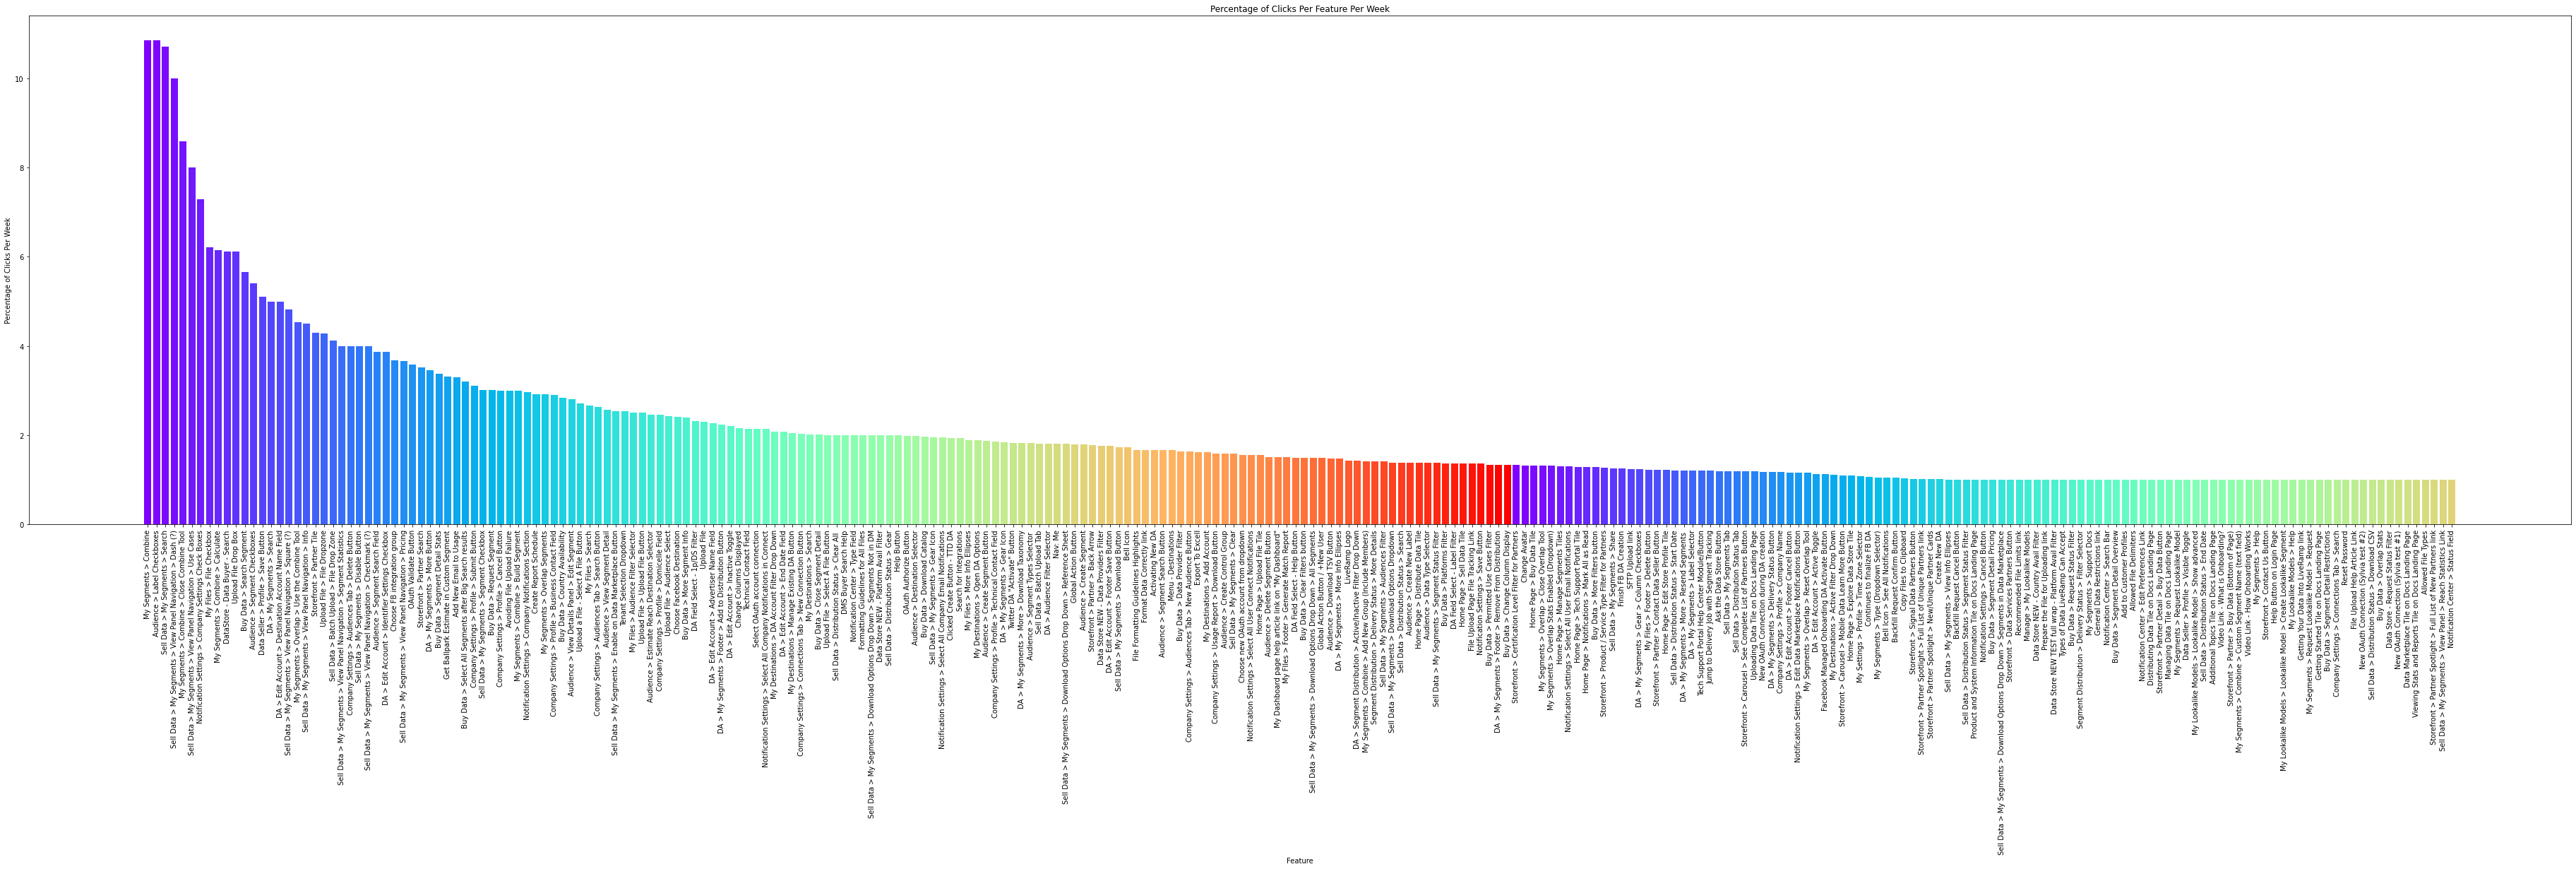

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Audience - Distribution 
 15.896726 
 
 
 Segment - Lookalike Models 
 11.433366 
 
 
 Audience - Users 
 8.379313 
 
 
 Buy Data 
 6.470423 
 
 
 Uploading Data - Formatting Column-Based Files 
 6.000000 
 
 
 Dynamic Yield - Onboard DA 
 6.000000 
 
 
 File Upload Simple Onboarding 
 5.890084 
 
 
 Additional Topics - File-Based Recognition Workflow 
 5.360812 
 
 
 
 
 
 
 feature 
 
 
 
 
 My Segments > Combine 
 10.856631 
 
 
 Audience > Label Checkboxes 
 10.853545 
 
 
 Sell Data > My Segments > Search 
 10.706856 
 
 
 Sell Data > My Segments > View Panel Navigation > Dash (?) 
 10.000000 
 
 
 My Segments > Combine > Close Combine Tool 
 8.591398 
 
 
 Sell Data > My Segments > View Panel Navigation > Use Cases 
 8.000000 
 
 
 Notification Settings > Company Settings Check Boxes 
 7.289128 
 
 
 My Files > File Checkbox 
 6.218312

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 6)



PERSONA CLUSTER: 7 

NUMBER OF USERS IN CLUSTER: 670.0 

PERCENTAGE OF USERS IN CLUSTER: 10.964 



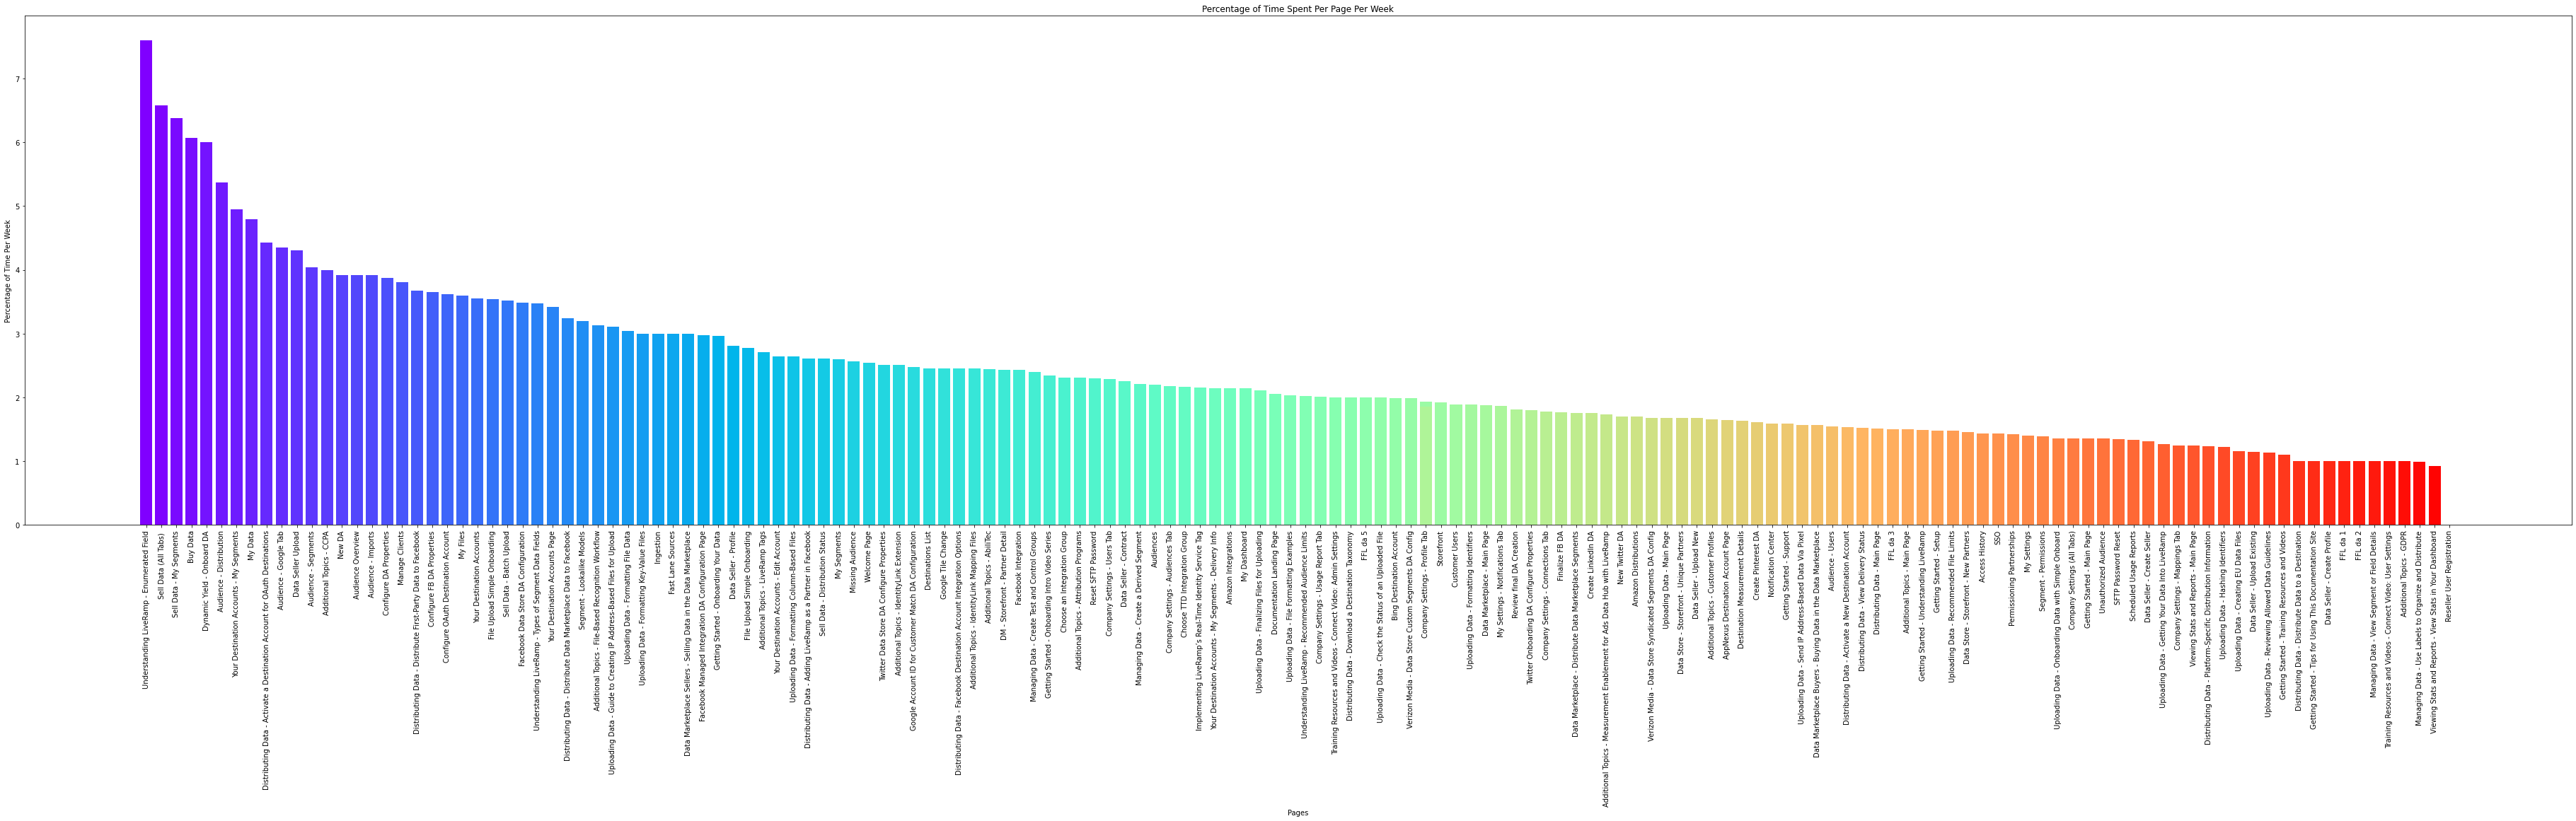

<Figure size 432x288 with 0 Axes>

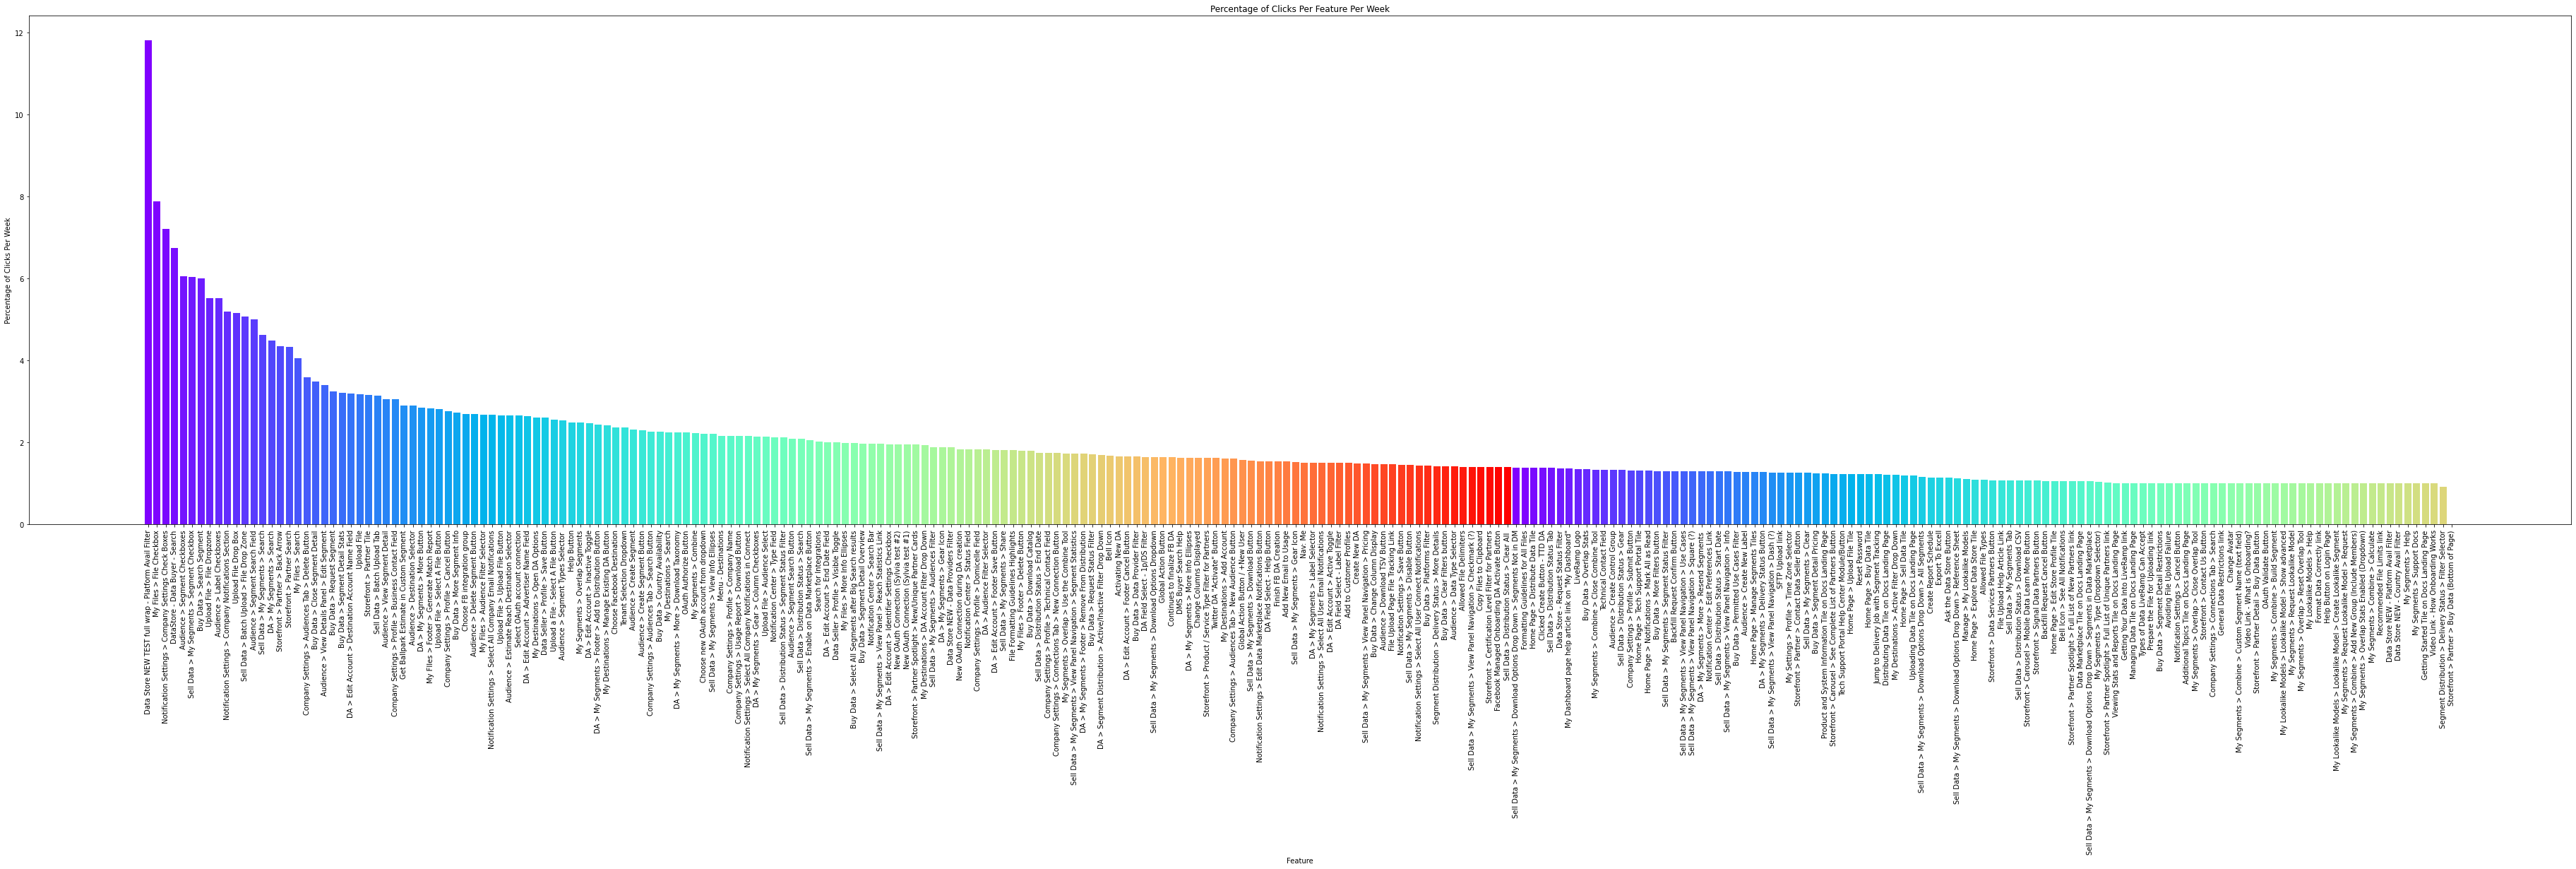

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Understanding LiveRamp - Enumerated Field 
 7.600000 
 
 
 Sell Data (All Tabs) 
 6.574354 
 
 
 Sell Data - My Segments 
 6.382995 
 
 
 Buy Data 
 6.068801 
 
 
 Dynamic Yield - Onboard DA 
 6.000000 
 
 
 Audience - Distribution 
 5.371771 
 
 
 Your Destination Accounts - My Segments 
 4.950203 
 
 
 My Data 
 4.795678 
 
 
 
 
 
 
 feature 
 
 
 
 
 Data Store NEW TEST full wrap - Platform Avail Filter 
 11.819403 
 
 
 My Files > File Checkbox 
 7.889675 
 
 
 Notification Settings > Company Settings Check Boxes 
 7.214925 
 
 
 DataStore - Data Buyer - Search 
 6.742464 
 
 
 Audience > Segment Checkboxes 
 6.050857 
 
 
 Sell Data > My Segments > Segment Checkbox 
 6.047784 
 
 
 Buy Data > Search Segment 
 6.007782 
 
 
 Upload File > File Dropzone 
 5.519933

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_1, 8, 7)

Doing the above for each cluster reveals using all the features and pages clutter our understanding of the grouping

##Iteration 2: KMeans, PCA, Daily Percentage Data
This iteration kept everything the same as the previous except for the data preprocessing and feature selection (we used only a subset of pages as our clustering features). We aggregated the interaction data by day and created percentages out of it in order to more easily compare across users that spend different amounts of time in the platform and ensure we are not over indexing on that metric in our clustering (i.e. user X spends 50% of their time on page Y per day, 10% on page Z). The results did not seem to have as much structure as our first iteration visually. After reviewing with our internal data science team we uncovered that our data was likely not suited for PCA and KMeans since it is sparse, nonlinear, categorical, and non-normally distributed. But the results seemed to be more promising from a cluster interpretability perspective, with significant and legible differences per cluster that could be used to come up with persona labels. The resulting 8 personas that were generated, though, seemed too granular in comparison to qualitative personas being pieced together from interviews. When diminishing the K value, we would lose clusters representing personas we knew to be separate and distinct from interviews but seemed to not have enough signal to warrant its own grouping in the data. 

###Clustering

In [ ]:
#Dataset we will use to base our clustering on this iteration
%%bigquery --project uxr-design-us-dev percentage_per_day_df
SELECT * FROM `uxr-design-us-dev.clustering_datasets.time_percentage_clustering_data`

In [ ]:
#Grabbing the ids and names to create a table of relevant clustering features
%%bigquery --project uxr-design-us-dev id_name_mapping
SELECT distinct feature_id as id, feature_name as name, page_id as parent_id, page_name as parent_name, group_name, is_core_event, app, "feature" as type 
FROM `mixed_methods_clustering.all_features_telemetry_data_per_week_deduped`

UNION ALL

SELECT distinct page_id as id, page_name as name, "" as parent_id, "" as parent_name, group_name, False as is_core_event, app, "page" as type 
FROM `mixed_methods_clustering.all_pages_telemetry_data_per_week_deduped`

In [ ]:
#IDs of the relevant pages and features in the average percentage dataset
ids = percentage_per_day_df.columns.to_list()[2::]

#Create mapping table of reformatted id to name
id_name_mapping["reformatted_id"] = "_" + id_name_mapping["id"].str.replace('-', '_')
id_name_mapping = id_name_mapping[id_name_mapping["reformatted_id"].isin(ids)]

#Create list of page names and ids
page_names = id_name_mapping[id_name_mapping["type"] == "page"]["name"].to_list()
p_ids = id_name_mapping[id_name_mapping["type"] == "page"]["reformatted_id"].to_list()

#Create list of feature names and ids
feature_names = []
f_ids = []

#All clustering feature ids
feature_ids = p_ids + f_ids

In [ ]:
iter_2_clustering_df = percentage_per_day_df.copy()

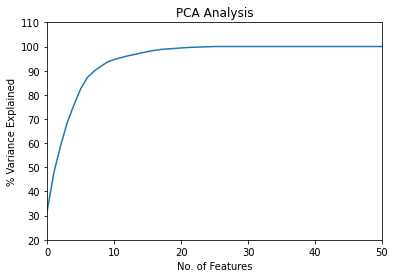

In [ ]:
#Find optimal number of features to reduce to by the number of features that allow us to capture 90% of the data's variance
plot_pca_variance_to_features(len(feature_ids), iter_2_clustering_df[feature_ids])

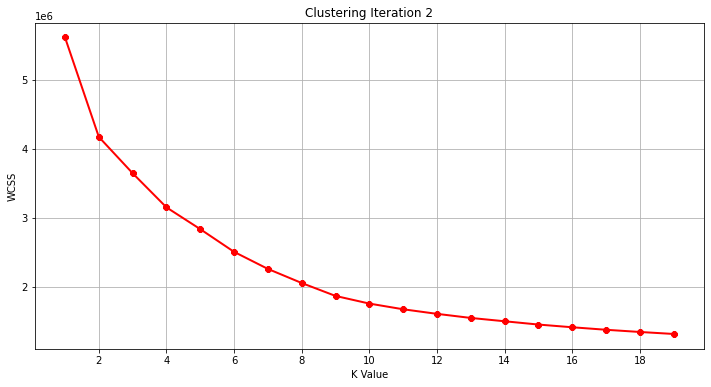

In [ ]:
#Plot the elbow curve to find the best value for k
plot_elbow_curve(iter_2_clustering_df[feature_ids], "Clustering Iteration 2") 

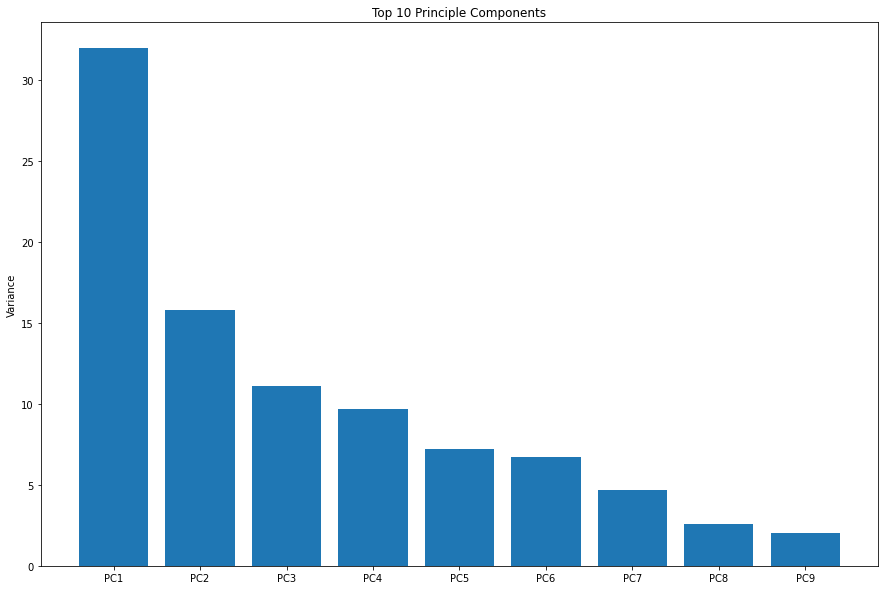

In [ ]:
#From the graph above, we want to use 200 features to keep 90% of the variance
pca = PCA(n_components=9)
data = pca.fit_transform(iter_2_clustering_df[feature_ids])

plt.figure(figsize=(15,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = ['PC'+ str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1)[0:10], height = var[0:10], tick_label = lbls[0:10])
plt.ylabel('Variance')
plt.title('Top 10 Principle Components')
plt.show()

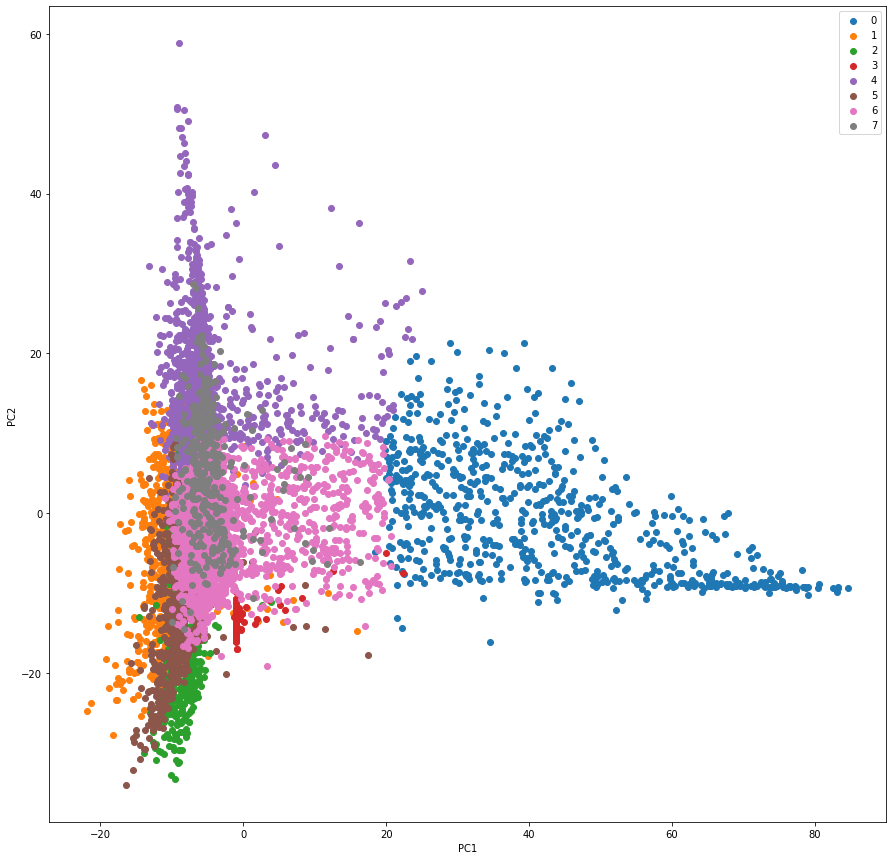

clustering_iter_2
6    2097
4    1322
1     732
0     696
5     656
7     390
2     326
3     106
Name: count, dtype: int64

In [ ]:
kmeans_summary_2 = kmeans_clustering_aves(8, data, iter_2_clustering_df, "clustering_iter_2")
kmeans_summary_2["count"]

###Per Cluster Breakdown and Persona Labels



PERSONA CLUSTER: 0 

NUMBER OF USERS IN CLUSTER: 696.0 

PERCENTAGE OF USERS IN CLUSTER: 11.004 



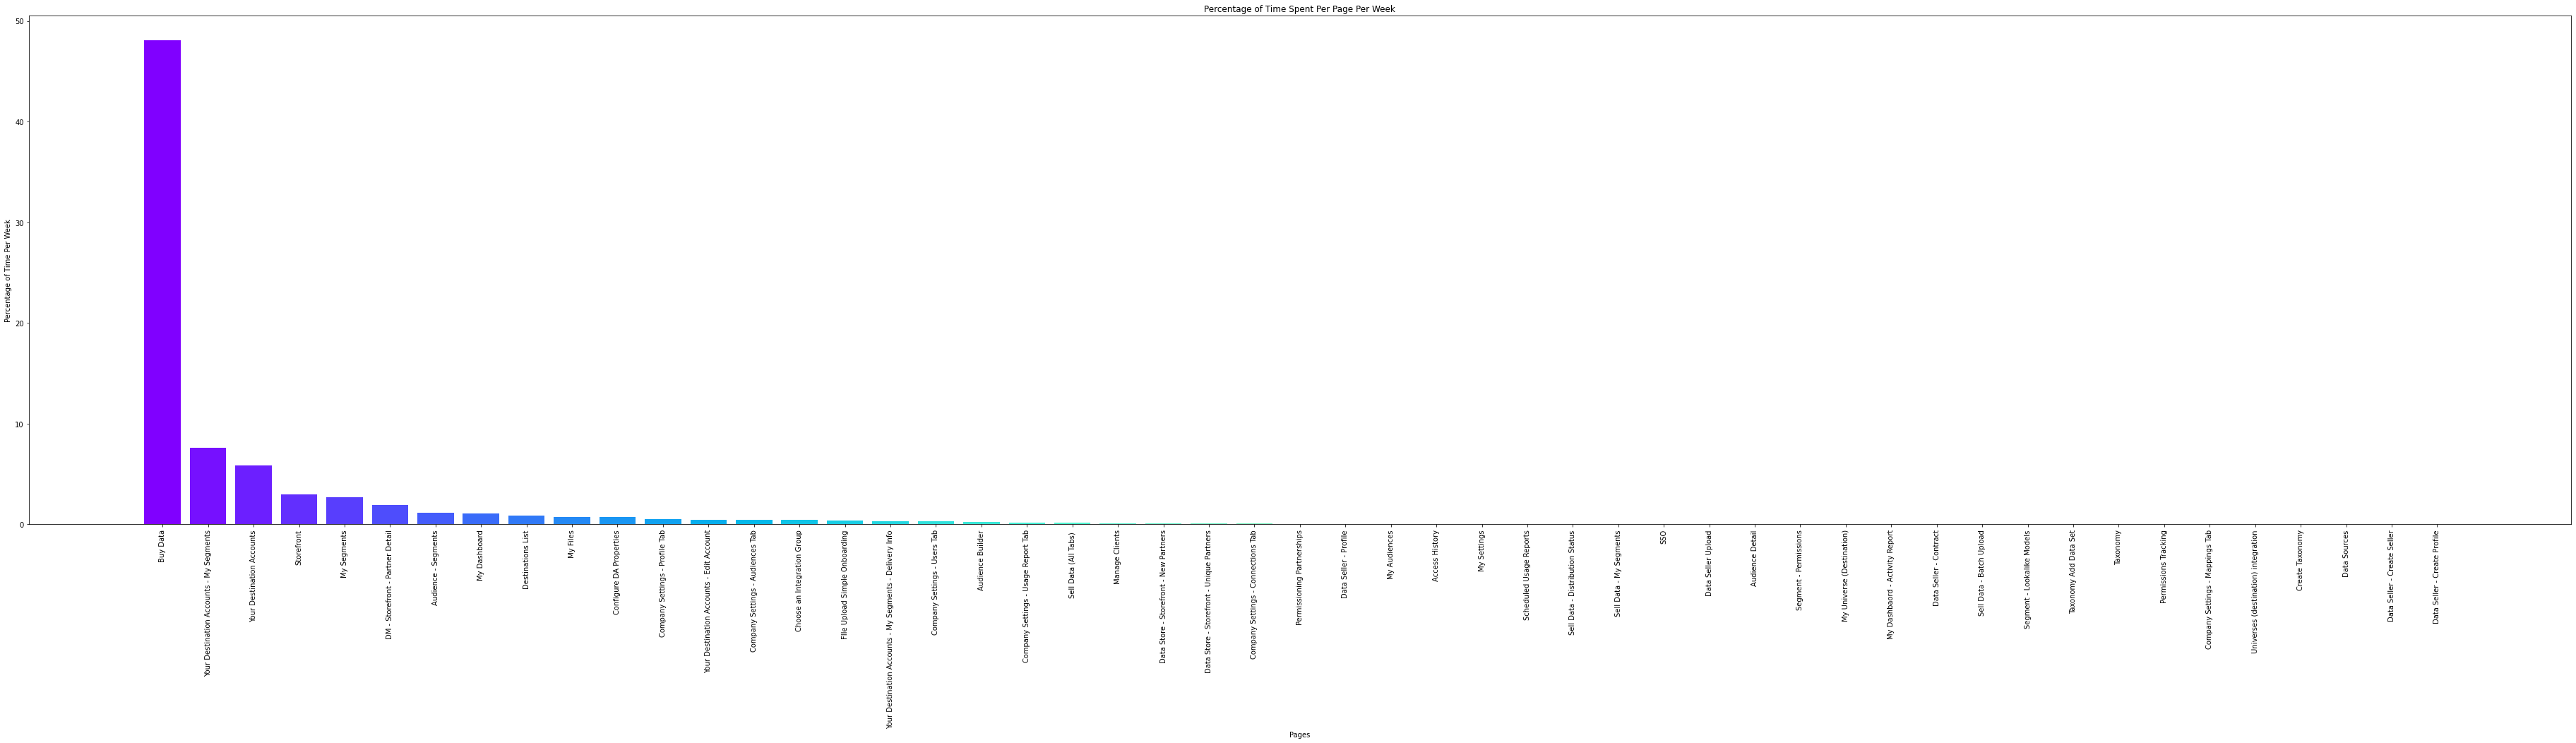

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Buy Data 
 48.101580 
 
 
 Your Destination Accounts - My Segments 
 7.623276 
 
 
 Your Destination Accounts 
 5.811494 
 
 
 Storefront 
 2.955029 
 
 
 My Segments 
 2.705747 
 
 
 DM - Storefront - Partner Detail 
 1.905316 
 
 
 Audience - Segments 
 1.109483 
 
 
 My Dashboard 
 1.058046 
 
 
 Destinations List 
 0.881753 
 
 
 My Files 
 0.702874

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 0)



PERSONA CLUSTER: 1 

NUMBER OF USERS IN CLUSTER: 732.0 

PERCENTAGE OF USERS IN CLUSTER: 11.573 



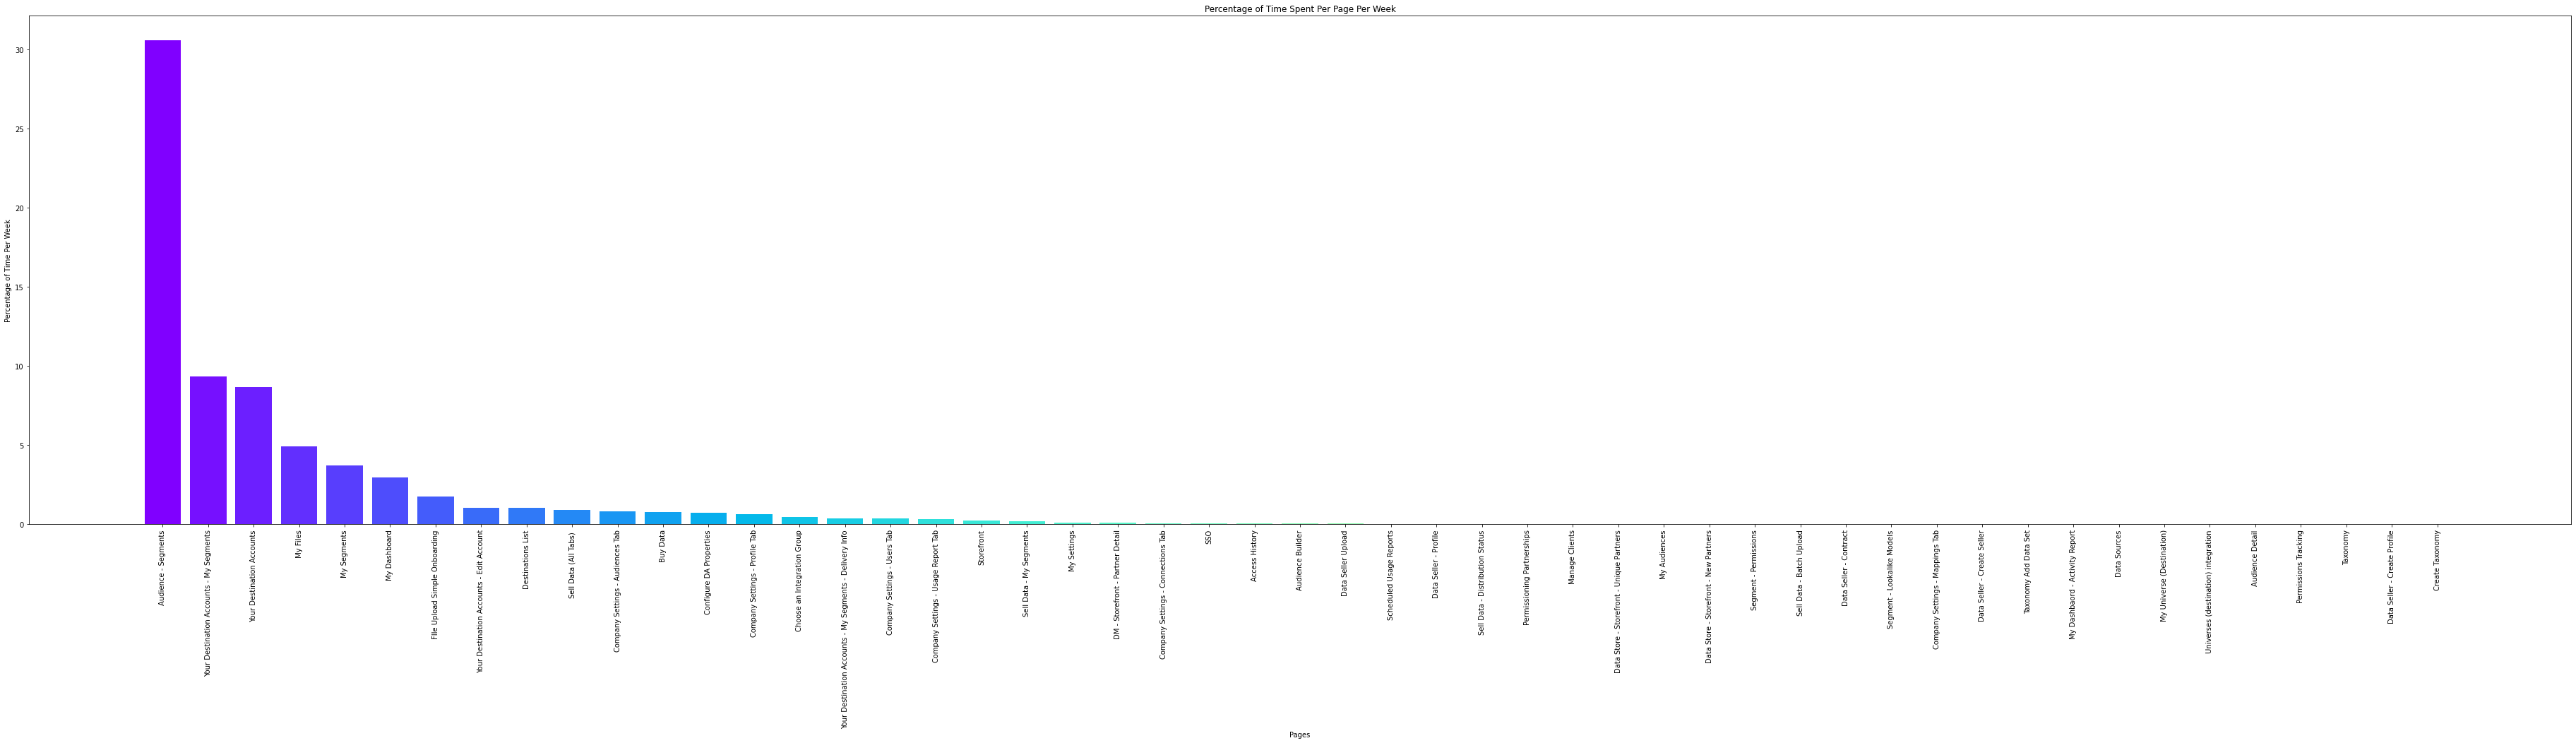

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Audience - Segments 
 30.608197 
 
 
 Your Destination Accounts - My Segments 
 9.323634 
 
 
 Your Destination Accounts 
 8.664891 
 
 
 My Files 
 4.905055 
 
 
 My Segments 
 3.727596 
 
 
 My Dashboard 
 2.961885 
 
 
 FIle Upload Simple Onboarding 
 1.733470 
 
 
 Your Destination Accounts - Edit Account 
 1.031831 
 
 
 Destinations List 
 1.025137 
 
 
 Sell Data (All Tabs) 
 0.928142

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 1)



PERSONA CLUSTER: 2 

NUMBER OF USERS IN CLUSTER: 326.0 

PERCENTAGE OF USERS IN CLUSTER: 5.154 



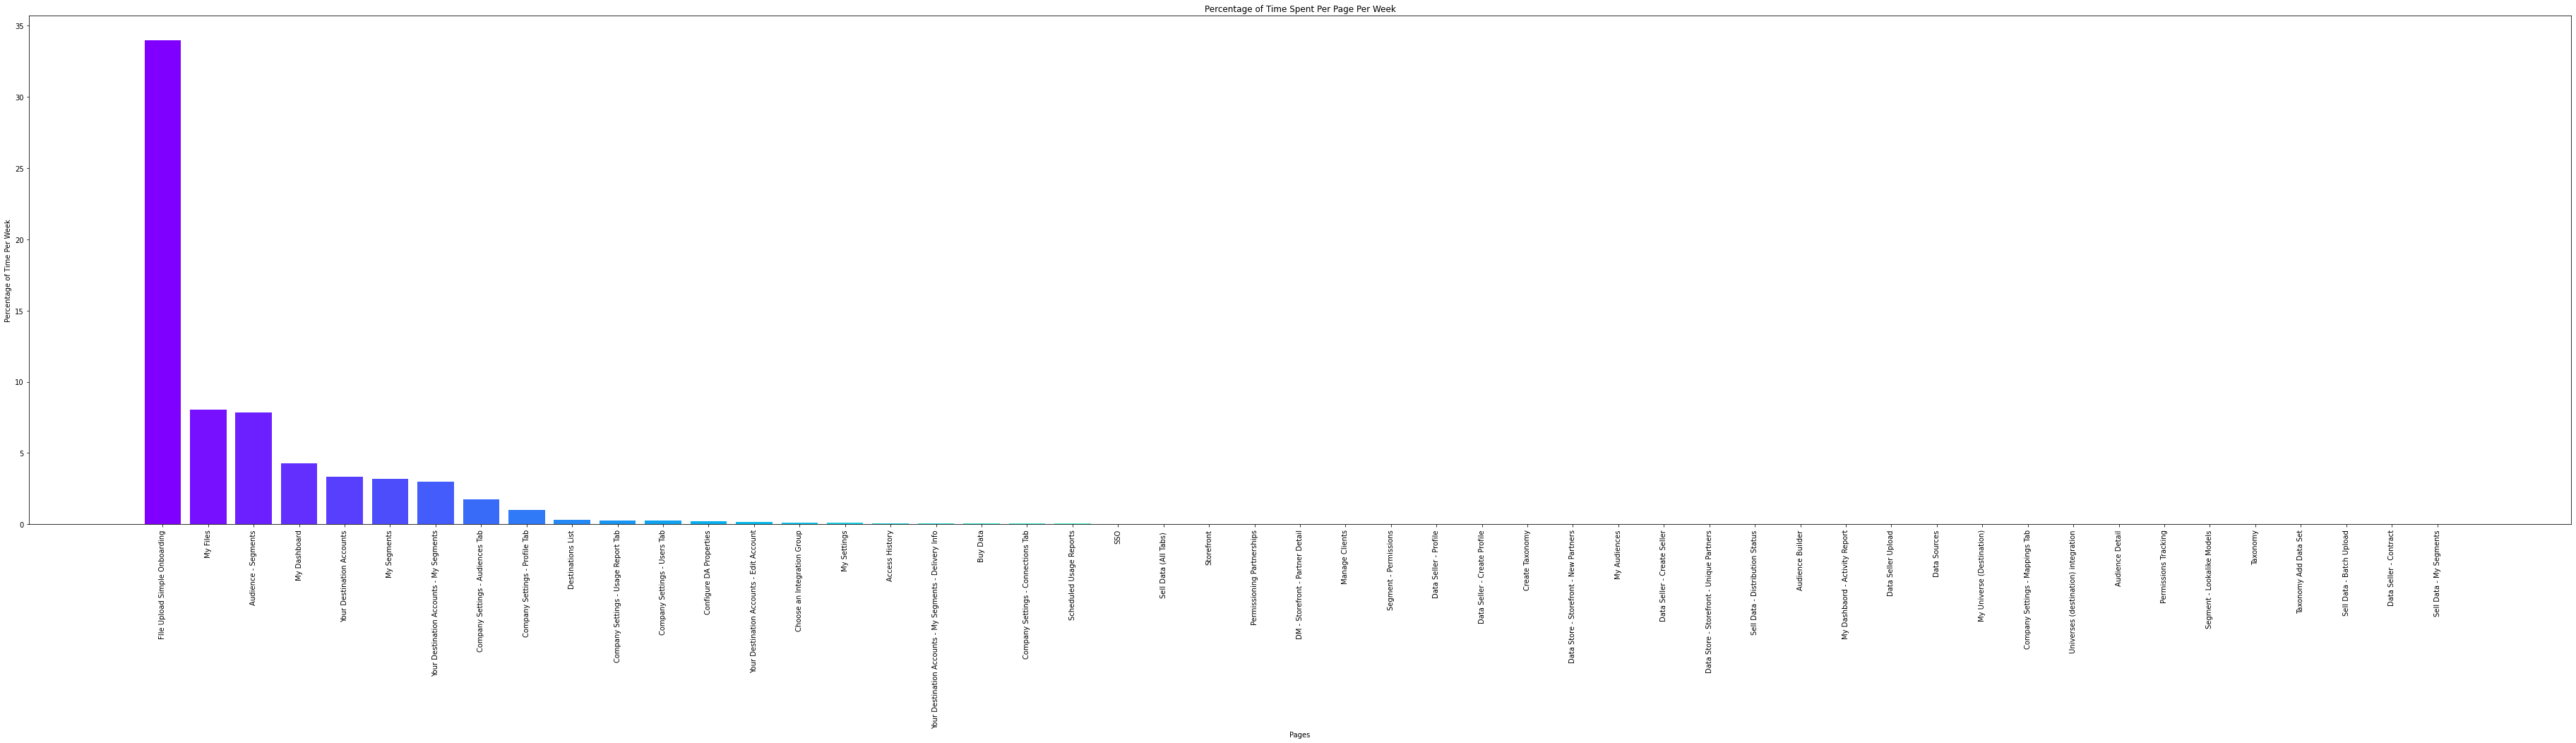

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 FIle Upload Simple Onboarding 
 33.996626 
 
 
 My Files 
 8.052454 
 
 
 Audience - Segments 
 7.869632 
 
 
 My Dashboard 
 4.257669 
 
 
 Your Destination Accounts 
 3.321472 
 
 
 My Segments 
 3.191718 
 
 
 Your Destination Accounts - My Segments 
 3.000000 
 
 
 Company Settings - Audiences Tab 
 1.771779 
 
 
 Company Settings - Profile Tab 
 0.992638 
 
 
 Destinations List 
 0.307362

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 2)



PERSONA CLUSTER: 3 

NUMBER OF USERS IN CLUSTER: 106.0 

PERCENTAGE OF USERS IN CLUSTER: 1.676 



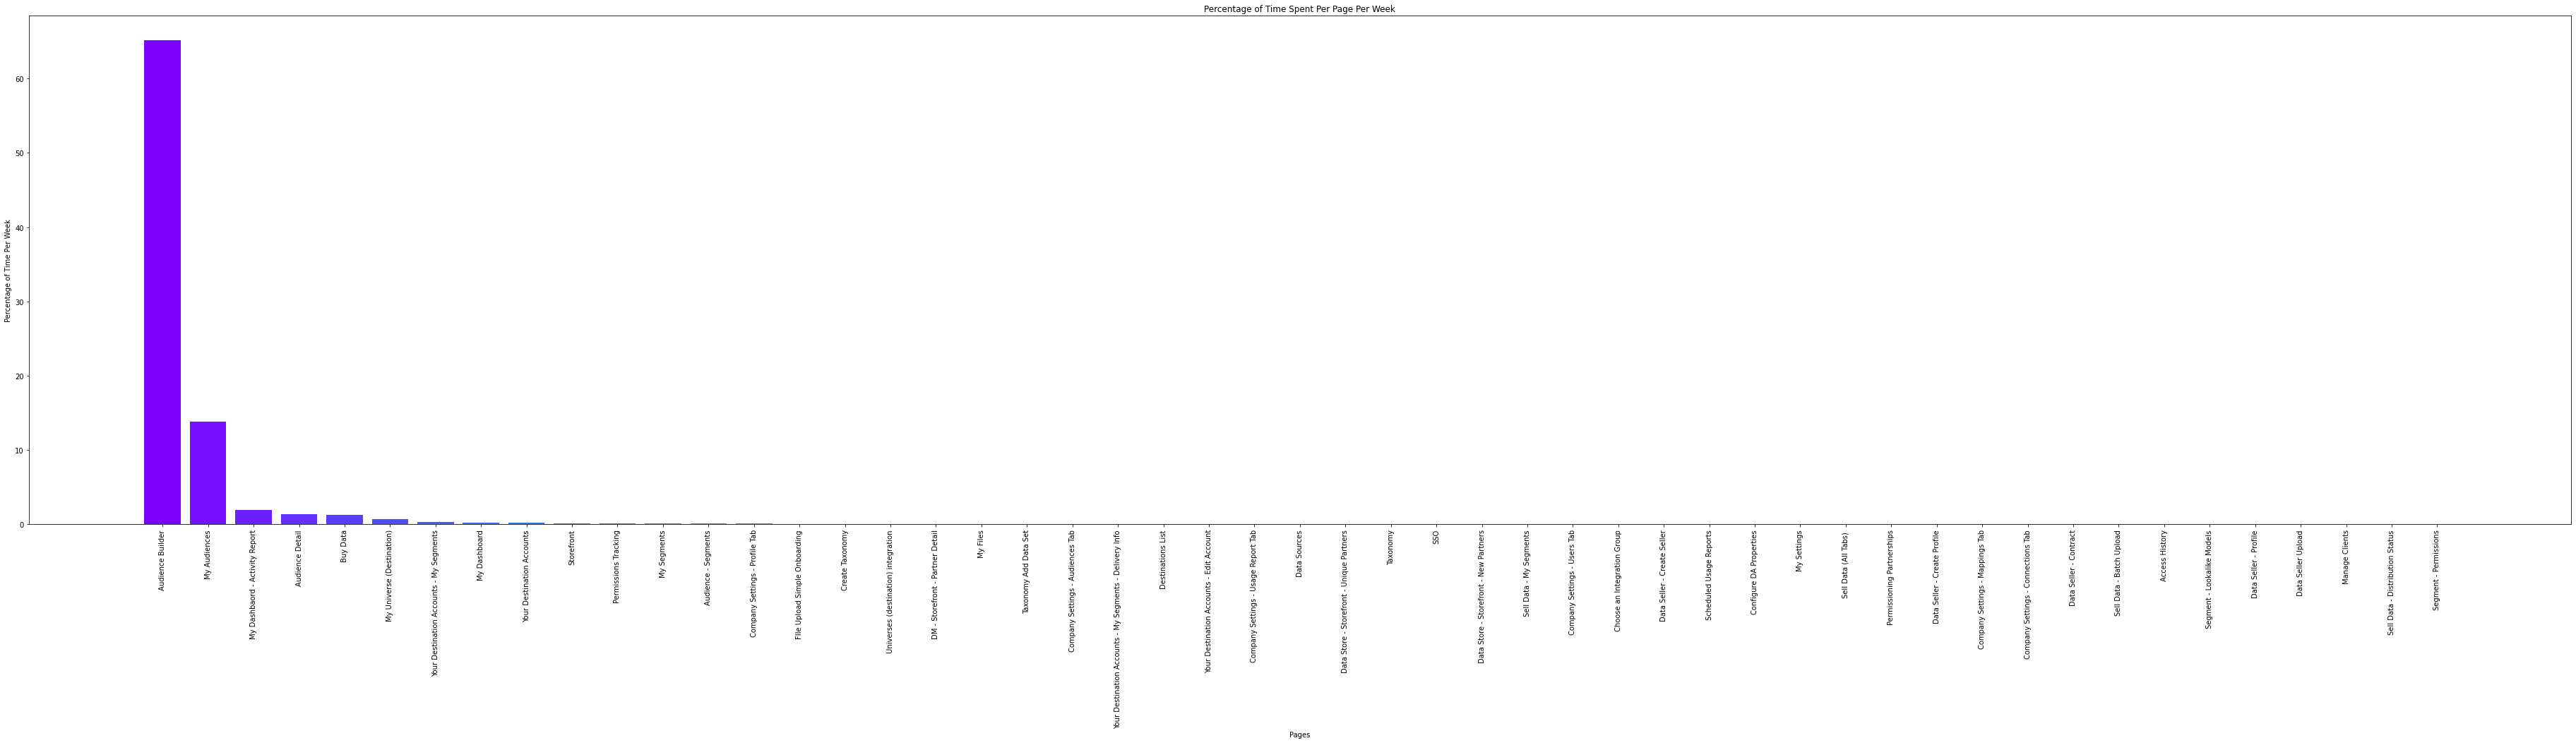

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Audience Builder 
 65.199057 
 
 
 My Audiences 
 13.781132 
 
 
 My Dashbaord - Activity Report 
 1.935849 
 
 
 Audience Detail 
 1.318868 
 
 
 Buy Data 
 1.230189 
 
 
 My Universe (Destination) 
 0.711321 
 
 
 Your Destination Accounts - My Segments 
 0.355660 
 
 
 My Dashboard 
 0.211321 
 
 
 Your Destination Accounts 
 0.190566 
 
 
 Storefront 
 0.139623

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 3)



PERSONA CLUSTER: 4 

NUMBER OF USERS IN CLUSTER: 1322.0 

PERCENTAGE OF USERS IN CLUSTER: 20.901 



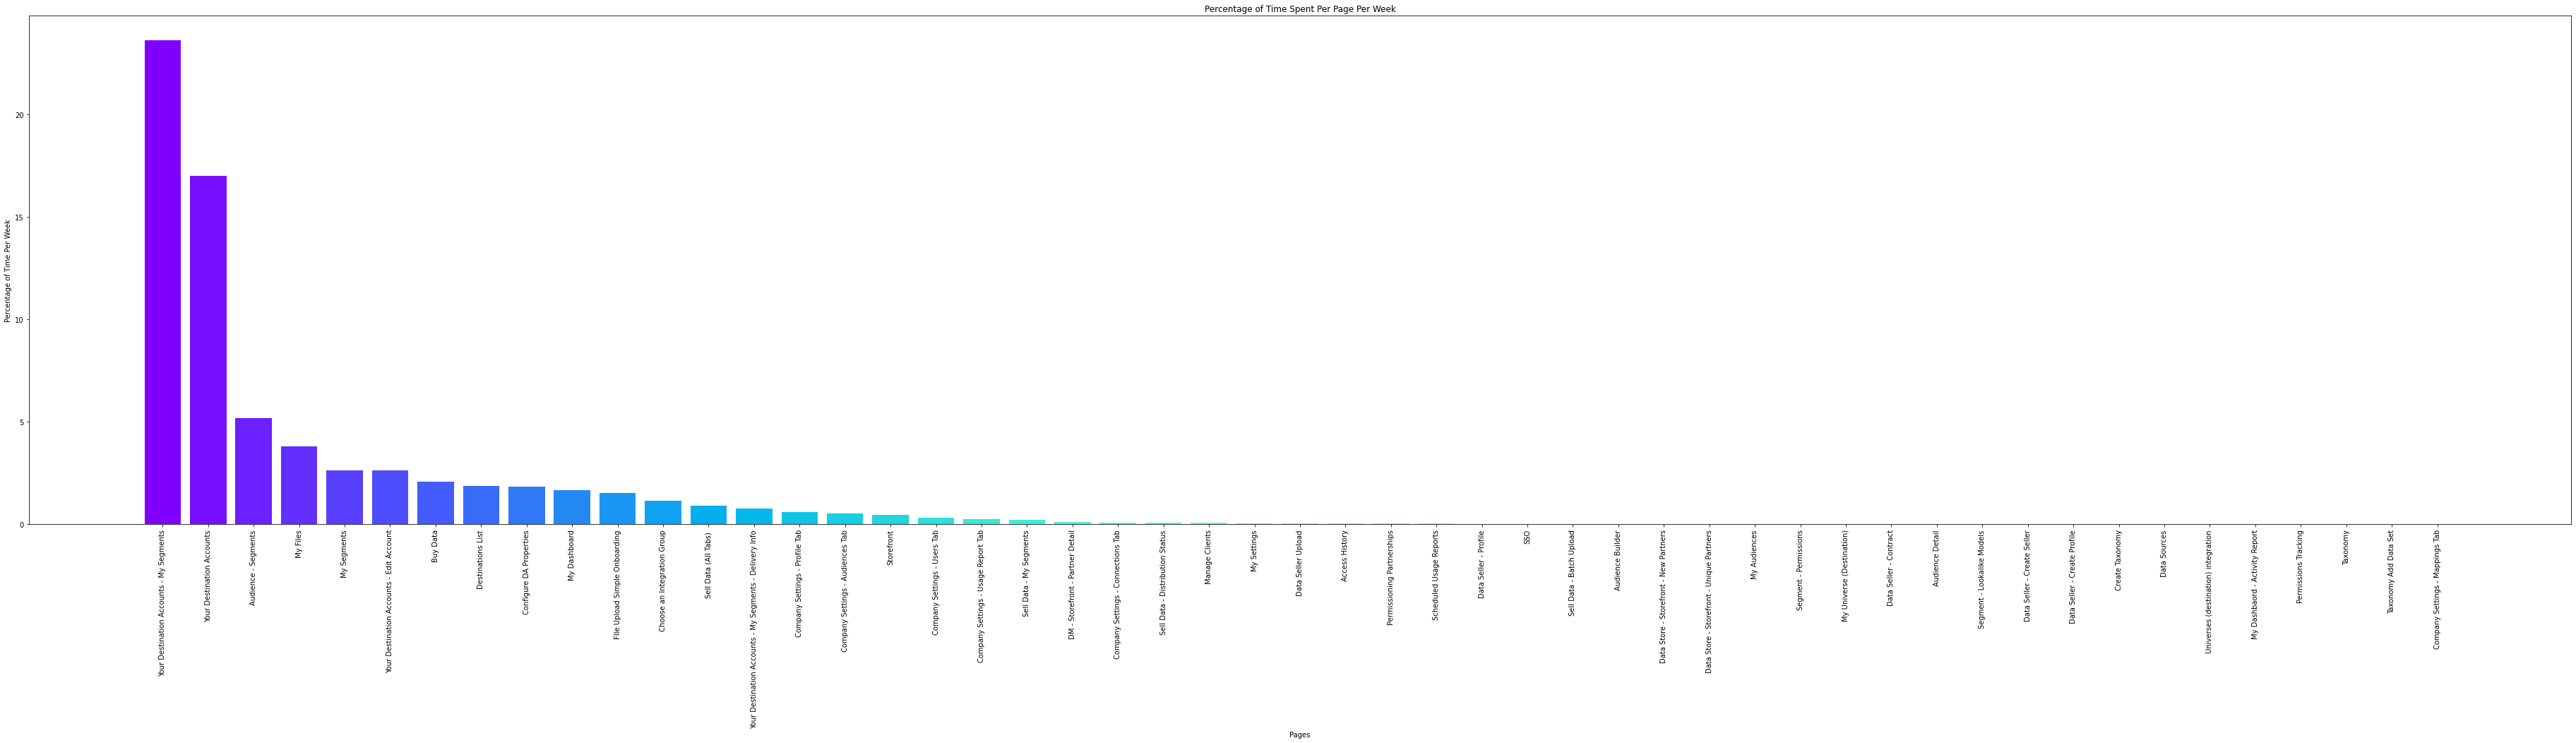

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Your Destination Accounts - My Segments 
 23.619818 
 
 
 Your Destination Accounts 
 17.006808 
 
 
 Audience - Segments 
 5.169138 
 
 
 My Files 
 3.805749 
 
 
 My Segments 
 2.622617 
 
 
 Your Destination Accounts - Edit Account 
 2.620045 
 
 
 Buy Data 
 2.090318 
 
 
 Destinations List 
 1.855900 
 
 
 Configure DA Properties 
 1.828215 
 
 
 My Dashboard 
 1.665582

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 4)



PERSONA CLUSTER: 5 

NUMBER OF USERS IN CLUSTER: 656.0 

PERCENTAGE OF USERS IN CLUSTER: 10.372 



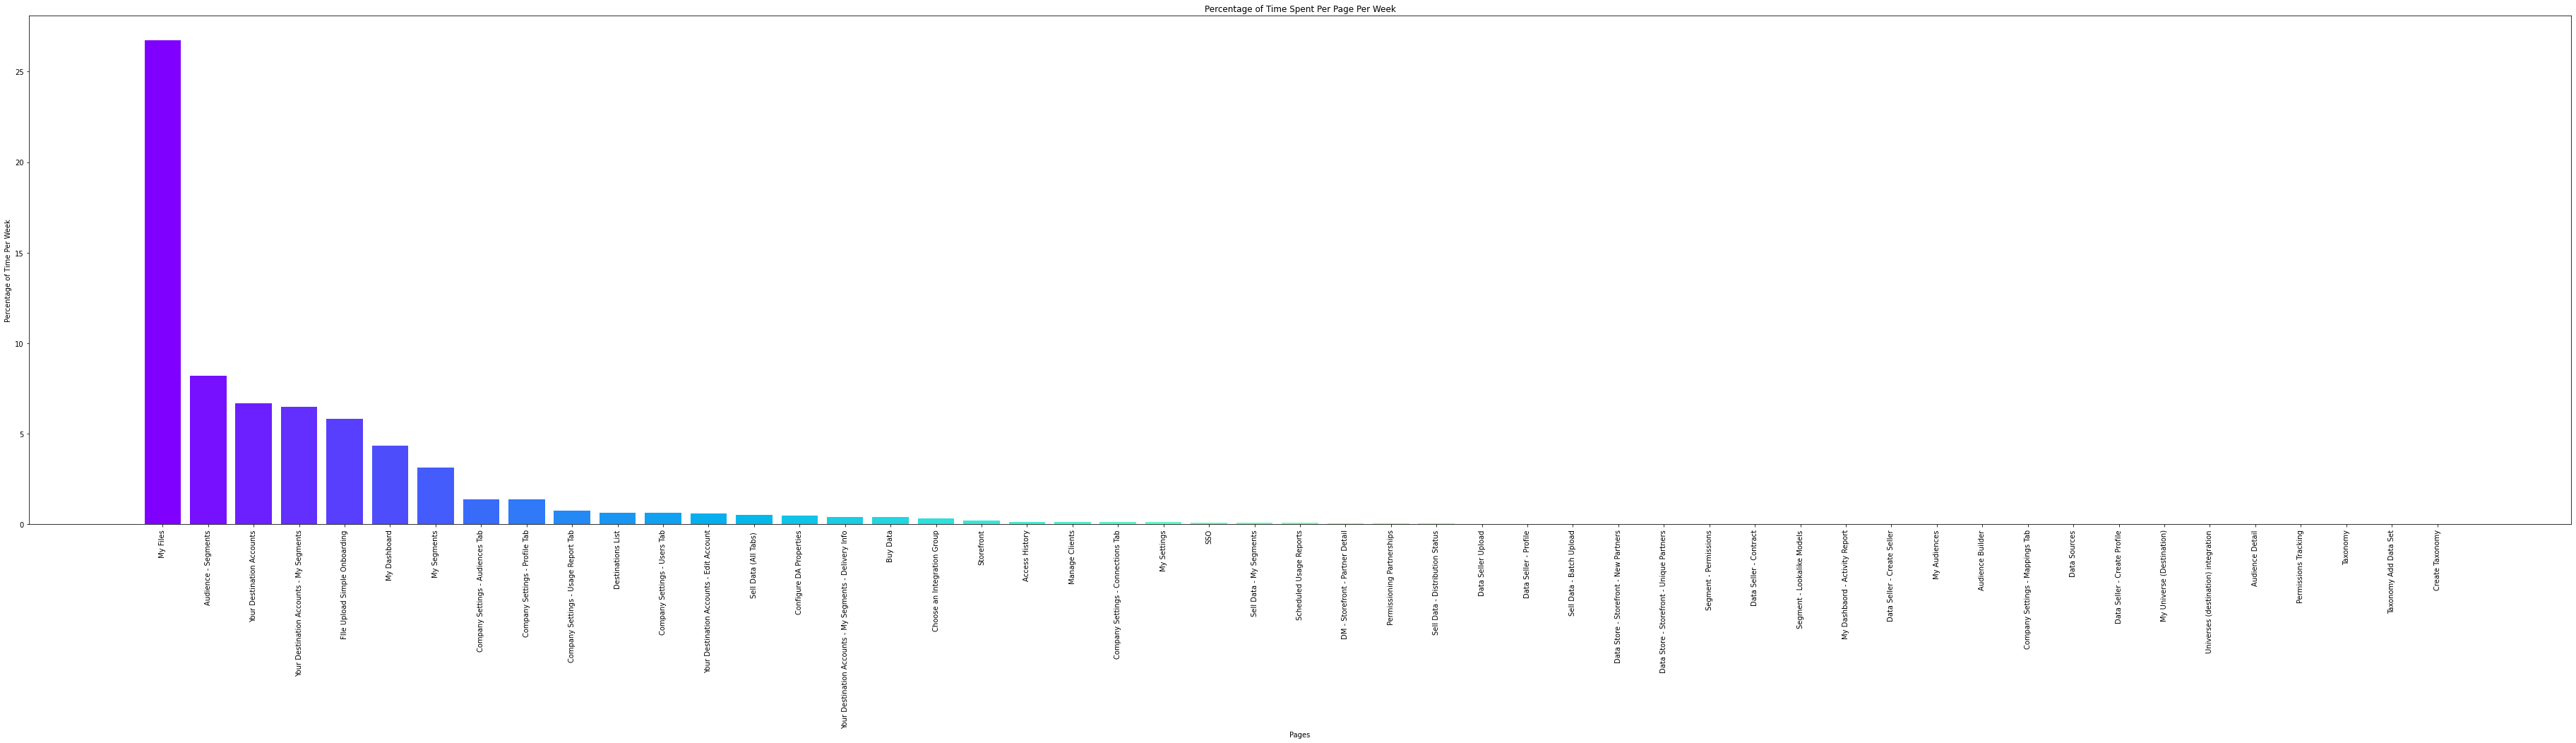

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 My Files 
 26.748780 
 
 
 Audience - Segments 
 8.201982 
 
 
 Your Destination Accounts 
 6.686585 
 
 
 Your Destination Accounts - My Segments 
 6.487348 
 
 
 FIle Upload Simple Onboarding 
 5.822104 
 
 
 My Dashboard 
 4.357622 
 
 
 My Segments 
 3.118140 
 
 
 Company Settings - Audiences Tab 
 1.371646 
 
 
 Company Settings - Profile Tab 
 1.364634 
 
 
 Company Settings - Usage Report Tab 
 0.742988

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 5)



PERSONA CLUSTER: 6 

NUMBER OF USERS IN CLUSTER: 2097.0 

PERCENTAGE OF USERS IN CLUSTER: 33.154 



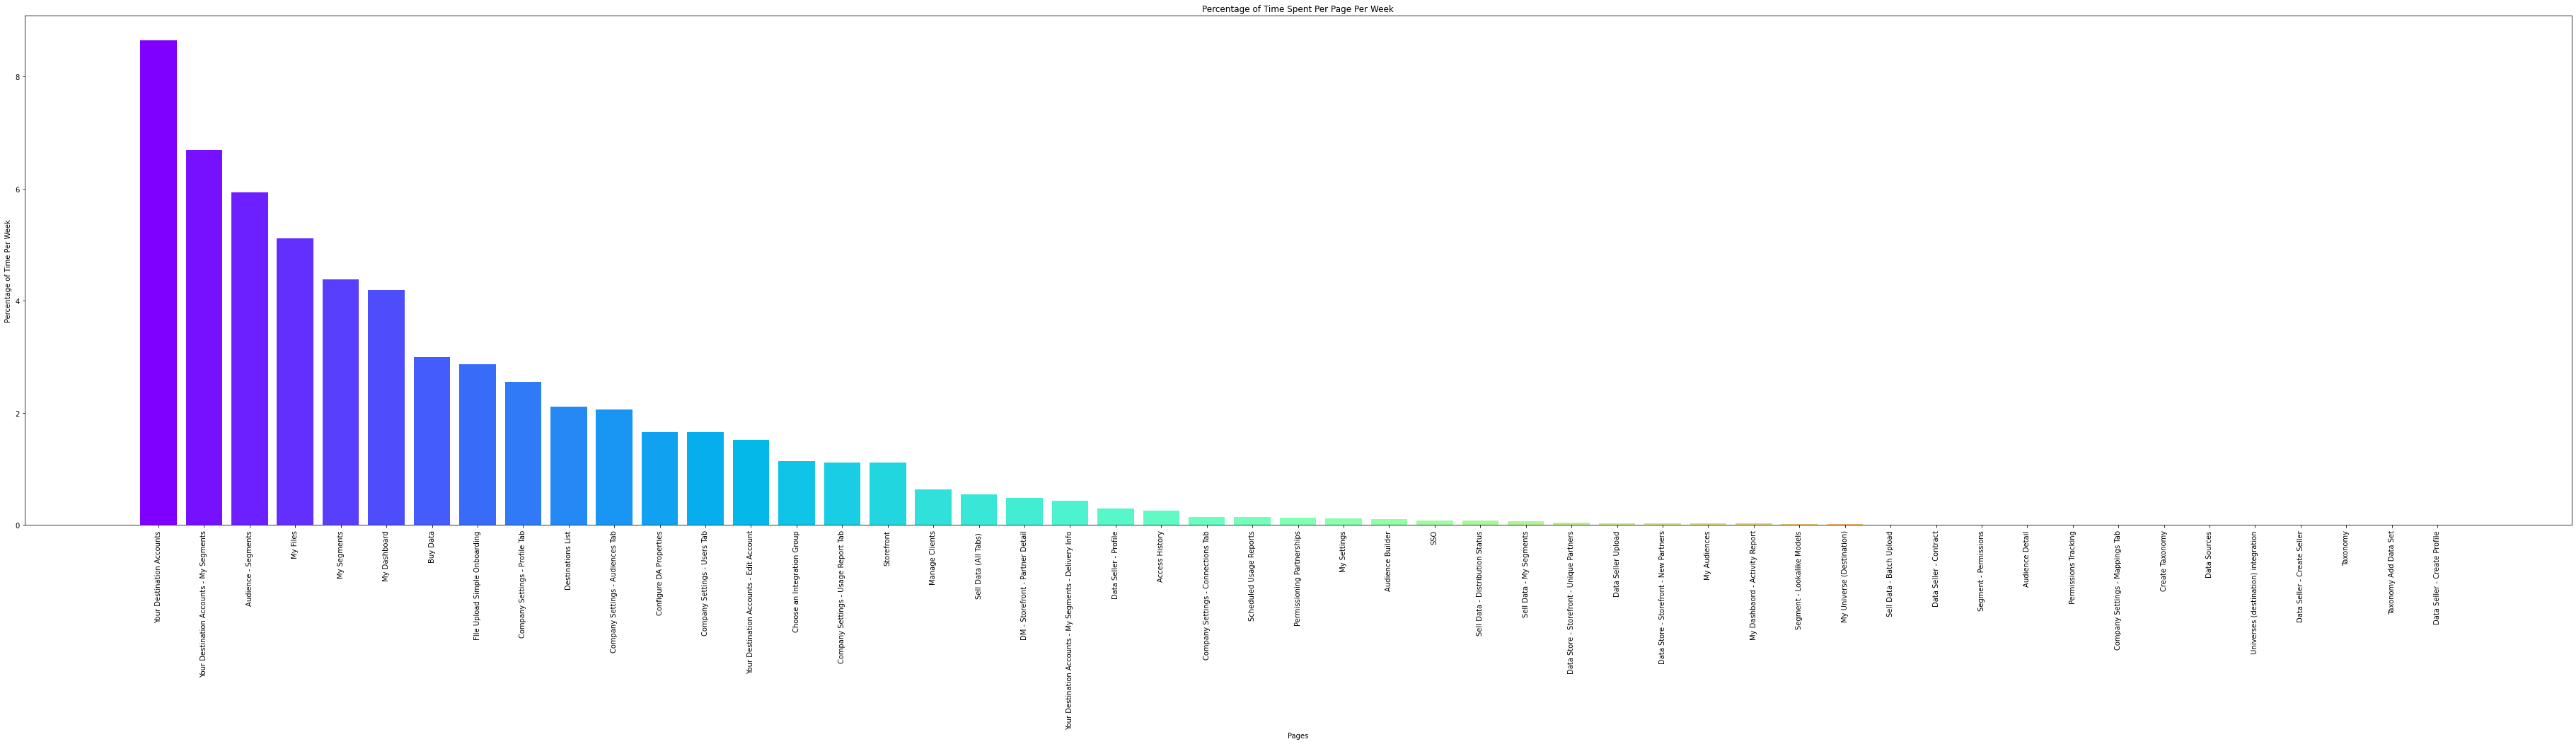

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Your Destination Accounts 
 8.653267 
 
 
 Your Destination Accounts - My Segments 
 6.694468 
 
 
 Audience - Segments 
 5.938531 
 
 
 My Files 
 5.119504 
 
 
 My Segments 
 4.382356 
 
 
 My Dashboard 
 4.192465 
 
 
 Buy Data 
 2.993038 
 
 
 FIle Upload Simple Onboarding 
 2.862423 
 
 
 Company Settings - Profile Tab 
 2.551216 
 
 
 Destinations List 
 2.110014

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 6)



PERSONA CLUSTER: 7 

NUMBER OF USERS IN CLUSTER: 390.0 

PERCENTAGE OF USERS IN CLUSTER: 6.166 



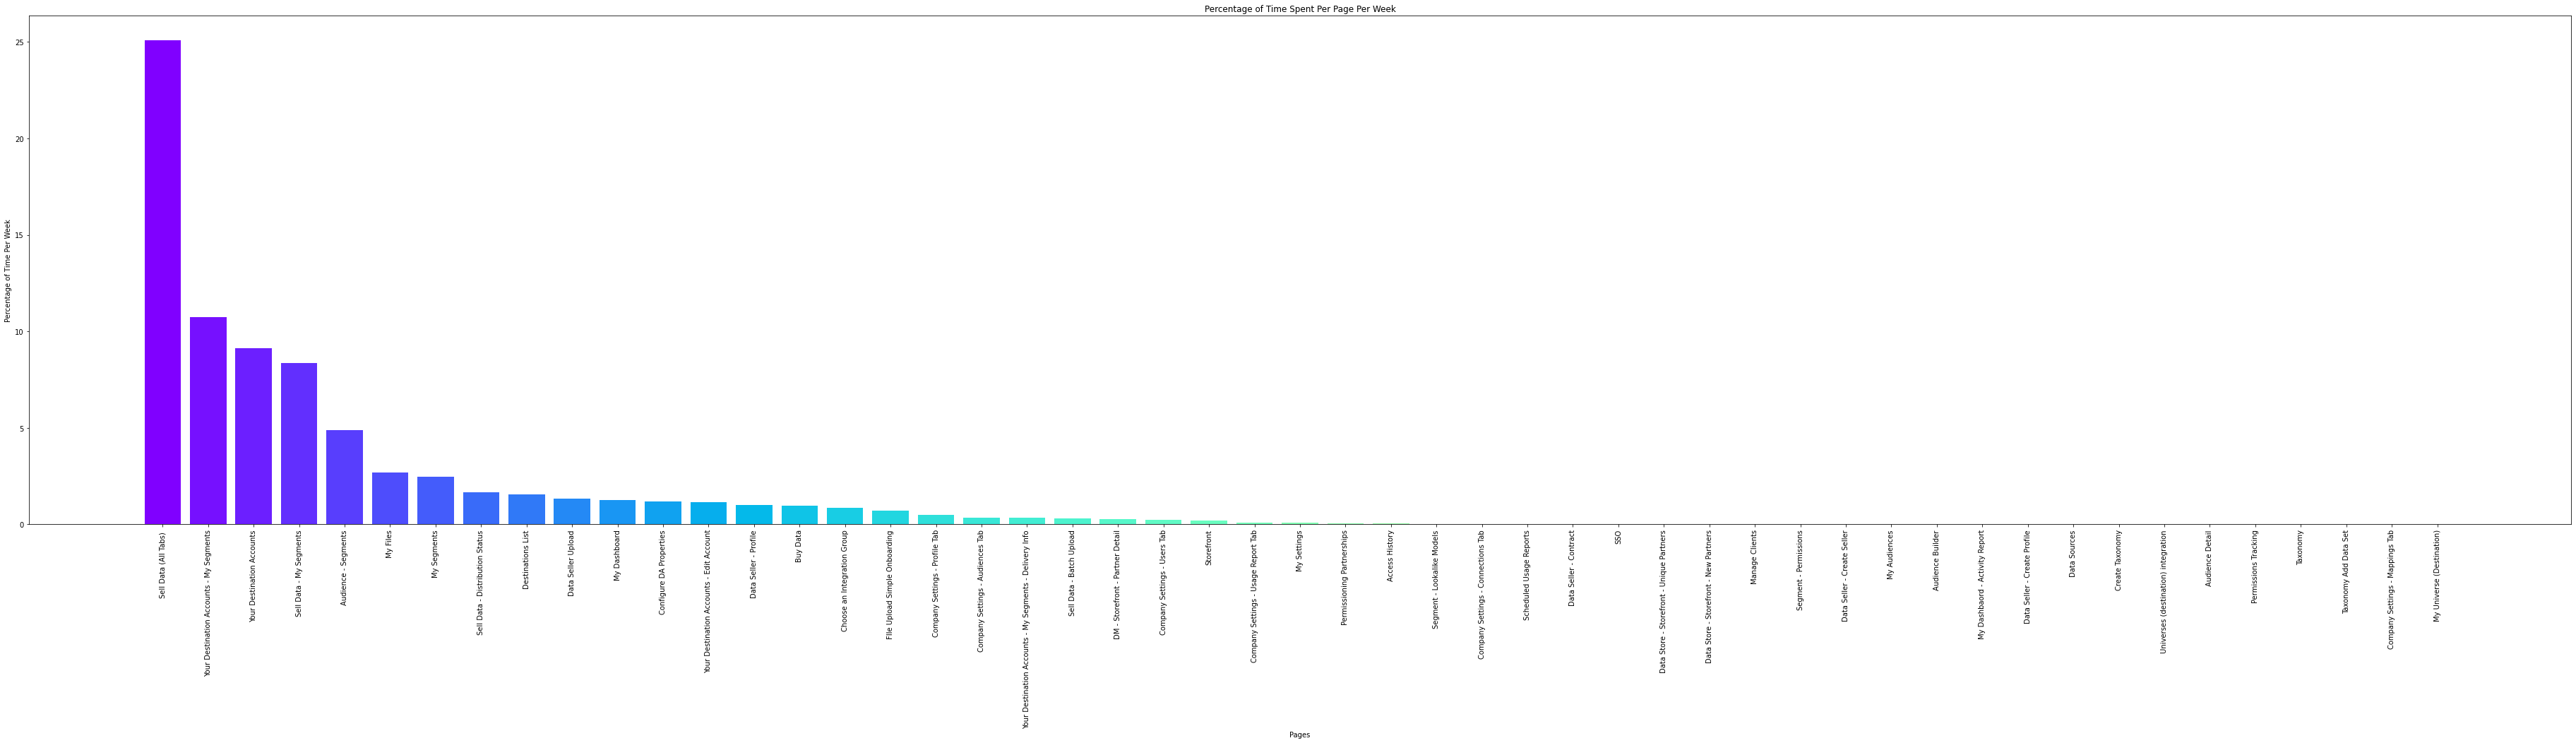

Top Pages on Left, Top Features on Right



page 
 
 
 
 
 Sell Data (All Tabs) 
 25.100513 
 
 
 Your Destination Accounts - My Segments 
 10.731282 
 
 
 Your Destination Accounts 
 9.113846 
 
 
 Sell Data - My Segments 
 8.372821 
 
 
 Audience - Segments 
 4.868462 
 
 
 My Files 
 2.684615 
 
 
 My Segments 
 2.457949 
 
 
 Sell Data - Distribution Status 
 1.674103 
 
 
 Destinations List 
 1.550000 
 
 
 Data Seller Upload 
 1.341026

In [ ]:
#Illuminate the cluster's details
cluster_means_and_plots_both(kmeans_summary_2, 10, 7)